# Importing libraries

In [1]:
import pandas as pd
import numpy as np

# Importing data

The previously exported cleaned dataset will be imported, picking up right where the previous notebook left off.

In [24]:
df = pd.read_csv(r"C:\Users\bakerai\Documents\BPP\professional prac\Assignment\Public\SteamDataCleaned.csv", dtype={"estimated_owners": "Int64"}, # need to upgrade estimated owners to int64, as when aggregating by genre values become too big.
    parse_dates=["release_date"])

df['release_date'] = df['release_date'].apply(pd.to_datetime, errors='coerce')
df = df.drop(columns=['Unnamed: 0'],axis=1)
df.describe()
pd.options.display.max_columns = 250

df.head(20)

appid                                             name release_date  \
0    221680  Rocksmith® 2014 Edition REMASTERED LEARN & PLAY   2024-12-19   
1   2962300                               Royal Quest Online   2024-12-19   
2   3253830                       Tank Arena:Total Operation   2024-12-19   
3   1910860                                         Grimlord   2024-12-19   
4   1850050                           Alien: Rogue Incursion   2024-12-19   
5   1244910                                   My Supermarket   2024-12-19   
6   3311560                                         重返现场：真人版   2024-12-19   
7   3227760                          Paper Bride 6 Nightmare   2024-12-19   
8   1001040                              Glorious Companions   2024-12-19   
9   3373390                               Hidden Cats - Snow   2024-12-19   
10  2796800                                    Tombstone MMO   2024-12-19   
11  2890890                              LingerieS / ランジェリーズ   2024-12-19   
12  3303780                                       CODE Bunny   2024-12-19   
13  3250980         Imperial Knightess Wein's Irregular Life   2024-12-19   
14  3213600           Store Wars: Multiplayer Shop Simulator   2024-12-19   
15  3244290                                     🌟K-POP STAR🌟   2024-12-19   
16  3374610                              Christmas Mutilator   2024-12-19   
17  2847380                                     Fallacy Quiz   2024-12-19   
18  3241520                                   SCP: Retrieval   2024-12-19   
19  2621850                                        SurviBall   2024-12-19   

    required_age  price  dlc_count  \
0              0   2.99       1191   
1              0   0.00          3   
2              0   0.00          0   
3              0  29.99          0   
4              0  39.99          0   
5              0   8.99          0   
6              0   9.99          0   
7              0   9.99          2   
8              0  19.99          0   
9              0   0.00          0   
10             0   0.00          0   
11             0   8.99          1   
12             0   9.99          0   
13             0   5.99          0   
14             0  12.99          0   
15             0   4.99          0   
16             0   5.99          0   
17             0  14.99          0   
18             0   7.99          0   
19             0   0.00          0   

                                 detailed_description  \
0   Rocksmith 2014 Remastered is back by popular d...   
1   Royal Quest Online is a free-to-play MMORPG th...   
2   《Tank Arena:Total Operation》 is a MMO competit...   
3   Join our Community! About the Game Welcome to ...   
4   Digital Deluxe Edition This Deluxe Edition inc...   
5   My SuperMarket is a third-person simulation ga...   
6   剧情介绍 本市女团冠军种子迟菲菲突遭车祸身亡，迟菲菲是安海大学在校学生，自小在孤儿院长大，经...   
7   Millennia pass like dreams; seas turn to field...   
8   Glorious Companions is a turn-based tactical R...   
9   Dive into the enchanting world of 'Hidden Cats...   
10  [EARLY ACCESS] Tombstone MMO is not your typic...   
11  This is Steam version. ◆Overview Players becom...   
12  Axel and Hazel are members of the VY Space Pro...   
13  【Storyline】 The Kingdom of Costodel. This is a...   
14  Welcome to the ultimate grocery store face-off...   
15  K-POP STAR is a provocative and daring visual ...   
16  Inspired by the gritty atmosphere and taut sus...   
17  Sharpen your critical thinking skills in this ...   
18  In SCP: Retrieval , the year is 1983, and the ...   
19  SurviBall is a fast-paced 3D platformer-puzzle...   

                                       about_the_game  \
0   Rocksmith 2014 Remastered is back by popular d...   
1   Royal Quest Online is a free-to-play MMORPG th...   
2   《Tank Arena:Total Operation》 is a MMO competit...   
3   Welcome to Grimlord - a Dark Fantasy Action So...   
4   Experience the universe of the Alien films lik...   
5   My SuperMarket is a third-person simulation g

# Bubble Visulisation

#### Now the data is cleaned, the EDA can begin, starting with the creation of the bubble visulisation.

To accomplish this, research was undertaken to find a suitable library to create this in. Plotly express was attempted first, but was unhappy with it's final apperance.

A D3 library made using HTML and JavaScript was identified - Called 'Zoomable circle packing'. (https://observablehq.com/@d3/zoomable-circle-packing - Mike Bostock, 2023)

The HTML and JavaScript will be generated within the Python code and export it as a .html. This will be interactable within the Github.


In [25]:
import pandas as pd
import json

# Only select those with > 10k estimated owners. Otherwise the visual may become hard to fit so many games in.
# Isolate the year from release year to filter on
df['release_year'] = pd.to_datetime(df['release_date']).dt.year

# Filtering to only select > 10k owners & those released >= 2004. This is to filter years where little data available, and games that have little owners which will clutter visual.
df_bubble = df[
    (df['estimated_owners'] > 10000 ) &
    (df['release_year'] >= 2004)
].copy()

# Build up a json structure.
# Structure by year, genre, and indicator (show_label) - control if label of game should be shown to avoid cluttering visual based on estimated_owners.
yearly_data = {} # Hold empty dictionary
for year, year_group in df_bubble.groupby(df_bubble['release_date'].dt.year): # Loop over each Year (year_group = all games from that year)
    genre_children = [] # Hold empty list to store genre groups per year
    for genre, genre_group in year_group.groupby('main_genre'): # Loop over genre per Year (genre_group = genres for that year)
        # Calculate 80th percentile. Those in 80'th percentile will have labels hidden - this is to avoid visual being too cluttered, as a lot of games.
        # If greater  than 80'th percentile: Return True, otherwise false.

        # Only apply threshold to very busy bubbles (main_genres)
        if len(genre_group) > 100:
            threshold = genre_group['estimated_owners'].quantile(0.8)
        else:
            threshold = 0
        # Loop over each game in genre, create dictionary that holds a games name, value (estimated_ownership to dictate bubble size), show_label
        #In keeping to avoid cluttering visual, the games name will be shortened if it exceeds 15 characters.
        shorten_labels = len(genre_group) > 100  # Only shorten if more than 100 games in genre
     
        game_children = [
            {
                "name": (row["name"][:17] + "...") if (shorten_labels and len(row["name"]) >= 20) else row["name"],  # shortened name for label. Slice on position 17, insert 3 character elipse's if len >= 20.
                "full_name": row["name"],  # full original name for hover tooltip
                "value": int(row["estimated_owners"]),
                "show_label": bool(row["estimated_owners"] > threshold) # Is owners > threshold?
            }
            for _, row in genre_group.iterrows()
        ]

        if game_children: # Check to only include in genre_children if not empty (shouldn't be needed but just incase)
            genre_children.append({"name": genre, "children": game_children}) # Add to that genre's node with children (game) 

    if genre_children:
        yearly_data[year] = {"name": str(year), "children": genre_children} # Add to year node


# Convert from Python to JSON - Required to work with javascript
data_json = json.dumps(yearly_data) # To be provided to the HTML to generate data upon

genres = sorted(df_bubble['main_genre'].unique())
genres_json = json.dumps(genres)

# In-line HTML code. Can be converted into standalone .html file, but for purposes of including everything in the notebook, it's being generated here.

html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Steam games per Year (Estimated Owners)</title>
  <script src="https://d3js.org/d3.v6.min.js"></script>
  <style>
    body {
      font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif;
      margin: 0;
      overflow: hidden;
      background: #defeff;
    }
    #chart-container {
      width: 100vw;
      height: 100vh;
      display: flex;
      justify-content: center;
      align-items: center;
    }
    #page-title {
    position: absolute;
    top: 20px;
    left: 30px;
    font-size: 1.6em;
    font-weight: 600;
    color: #222;
    background-color: rgba(255, 255, 255, 0.85);
    padding: 8px 16px;
    border-radius: 8px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.1);
    z-index: 10;
    }
    #slider-container {
      position: absolute;
      bottom: 25px;
      left: 50%;
      transform: translateX(-50%);
      background: rgba(255, 255, 255, 0.95);
      padding: 12px 25px;
      border-radius: 8px;
      box-shadow: 0 4px 12px rgba(0, 0, 0, 0.15);
      display: flex;
      align-items: center;
      gap: 15px;
      border: 1px solid #ddd;
    }
    #year-display {
      font-weight: 600;
      font-size: 1.3em;
      min-width: 60px;
      text-align: center;
      color: #333;
    }
    input[type=range] {
      width: 350px;
    }
  </style>
</head>
<body>

  <div id="page-title">Steam Games by Estimated Owners per Genre</div>

  <div id="chart-container"></div>

  <div id="slider-container">
    <label for="year-slider" style="font-weight: 500;">Year:</label>
    <span id="year-display"></span>
    <input type="range" id="year-slider" step="1">
  </div>

  <script>
    // Retreive data provided from Python
    const yearlyData = {DATA};
    const genres = {GENRES};

    // Build array of years. Grab all from yearlyData, convert string to number. Sort in ascending.
    const years = Object.keys(yearlyData).map(d => +d).sort((a, b) => a - b);
    
    const slider = document.getElementById("year-slider");
    const yearDisplay = document.getElementById("year-display");
    const container = document.getElementById("chart-container");

    // Start slider on first element
    slider.min = years[0];
    // Pick the last year, assign this as the max filterable date to. -1 as it's by index position (starts at 0)
    slider.max = years[years.length - 1];
    
    function drawChart(year) {
      container.innerHTML = ''; // Clear previous chart
      const data = yearlyData[year];

      // Specify chart dimensions based on container size
      const width = Math.min(container.clientWidth, container.clientHeight, 928) * 0.95;
      const height = width;

      // Color scale
      const color = d3.scaleLinear()
          .domain([0, 5])
          .range(["hsl(190, 60%, 80%)", "hsl(228, 30%, 40%)"])
          .interpolate(d3.interpolateHcl);

      // Pack layout configuration
      const pack = d3.pack()
        .size([width, height])
        .padding(d => d.depth === 0 ? 100 : 3); // Add padding between bubbles. Bigger spacing for root level (genres)

      // Create hierarchy layout from data
      const root = pack(d3.hierarchy(data)
          .sum(d => d.value) // Size circles by 'value' which is estimated__owners
          .sort((a, b) => b.value - a.value)); // Largest first

      // Create svg canvas
      const svg = d3.create("svg")
          .attr("viewBox", `-${width / 2} -${height / 2} ${width} ${height}`) 
          .attr("width", "95%")
          .attr("height", "95%")
          .attr("style", `max-width: 100%; height: 100%; display: block; background: #defeff; cursor: pointer;`);

      // Set focus and view state
      let focus = root;
      let view;

      // Append all node circles
      const node = svg.append("g")
        .selectAll("circle")
        .data(root.descendants().slice(1)) // skip the root itself
        .join("circle")
          .attr("fill", d => d.children ? color(d.depth) : "white")
          .attr("stroke", d => d.children ? null : "#bbb")
          .on("mouseover",function() { d3.select(this).attr("stroke", "#000"); })
          .on("mouseout", function() { d3.select(this).attr("stroke", d => d.children ? null : "#bbb"); })
		  // Ammended to prevent zooming on game.
          .on("click", (event, d) => { 
			  if (focus !== d) {
				const target = d.children ? d : d.parent;
				zoom(event, target);
				event.stopPropagation();
			  }
			})

      // Append labels
      const label = svg.append("g")
        .style("font", "12px sans-serif")
        .attr("pointer-events", "none")
        .attr("text-anchor", "middle")
        .selectAll("text")
        .data(root.descendants())
        .join("text")
          .style("fill-opacity", d => d.parent === root ? 1 : 0) // Show main genres initially. Ensures only main genre labels are visible.
          .style("display", d => d.parent === root ? "inline" : "none")
          .text(d => d.data.name)
          .attr("dy", "0.35em");

      // Tooltip on hover
      node.append("title")
        .text(d => `${d.data.full_name || d.data.name}\nOwners: ${d.value.toLocaleString()}`); // Show full name on hover


      // Append the final svg to container
      container.append(svg.node());

      // Zooming logic
      function zoomTo(v) {
        const k = width / v[2];
        view = v;
        label.attr("transform", d => `translate(${(d.x - v[0]) * k},${(d.y - v[1]) * k})`);
        node.attr("transform", d => `translate(${(d.x - v[0]) * k},${(d.y - v[1]) * k})`);
        node.attr("r", d => d.r * k);
      }

      function zoom(event, d) {
        focus = d;
        const transition = svg.transition()
            .duration(event.altKey ? 7500 : 750)
            .tween("zoom", () => {
              const i = d3.interpolateZoom(view, [focus.x, focus.y, focus.r * 2]);
              return t => zoomTo(i(t));
            });

        // Update label visibility on zoom
		// Changes to zoom logic: Hide labels on zoom if show_label 
		// If show_label = 1 (true) then show, if 0 (false) then set style display to none
			label
			  .transition(transition)
				.style("fill-opacity", d =>
				  focus === root
					? d.parent === root ? 1 : 0
					: d.parent === focus && d.data.show_label ? 1 : 0
				)
				.on("start", function(d) {
				  const shouldShow =
					focus === root
					  ? d.parent === root
					  : d.parent === focus && d.data.show_label;
				  if (shouldShow) this.style.display = "inline";
				})
				.on("end", function(d) {
				  const shouldHide =
					focus === root
					  ? d.parent !== root
					  : !(d.parent === focus && d.data.show_label);
				  if (shouldHide) this.style.display = "none";
				});


      }

      // Click on background to zoom out
      svg.on("click", (event) => zoom(event, root));
      // Initial focus
      zoomTo([root.x, root.y, root.r * 2]);
    }

    // On slider movement, update year & chart
    function update(year) {
      slider.value = year;
      yearDisplay.textContent = year;
      drawChart(year);
    }

    // Event listeners for slider and window resize
    slider.addEventListener("input", e => update(+e.target.value));
    window.addEventListener('resize', () => update(+slider.value));

    // Draw initial chart
    update(years[0]);
  </script>
</body>
</html>
"""


# Insert the JSON into the above html with json data.
# Data = Aggregated yearly ownership info.
# Genres = Unique list of genres.
final_html = (html_template.replace("{DATA}", data_json).replace("{GENRES}", genres_json)
)

output_filename = "Steam_Games_Per_Year_Estimated_Owners.html" # Outputting the .html
with open(output_filename, "w", encoding="utf-8") as f:
    f.write(final_html)

print("Done")

Done


# Results:

### 2011 Games released by Estimated Owners on Steam

<img src="https://raw.githubusercontent.com/AidanBakerNHS/SteamAppDataVisulisation/main/Assets/2011_BubbleVis.PNG"
     width="1200" height="1000"
     alt="2011 Games released by Estimated Owners on Steam">

### 2024 Games released by Estimated Owners on Steam

<img src="https://raw.githubusercontent.com/AidanBakerNHS/SteamAppDataVisulisation/main/Assets/2024_BubbleVis.PNG"
     width="1200" height="1000"
     alt="2024 Games released by Estimated Owners on Steam">


# EDA

This section will be function-based, to reduce code duplication and allow for modular access to running each element of the notebook.

## Word Clouds

In [26]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [27]:
# Keep a consistent colour scheme among all visuals and plots

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.get_cmap('tab20').colors) # Retains and uses the same 20 distinct colours

plt.rcParams['figure.dpi'] = 200 # Set global DPI size to avoid images being blurry

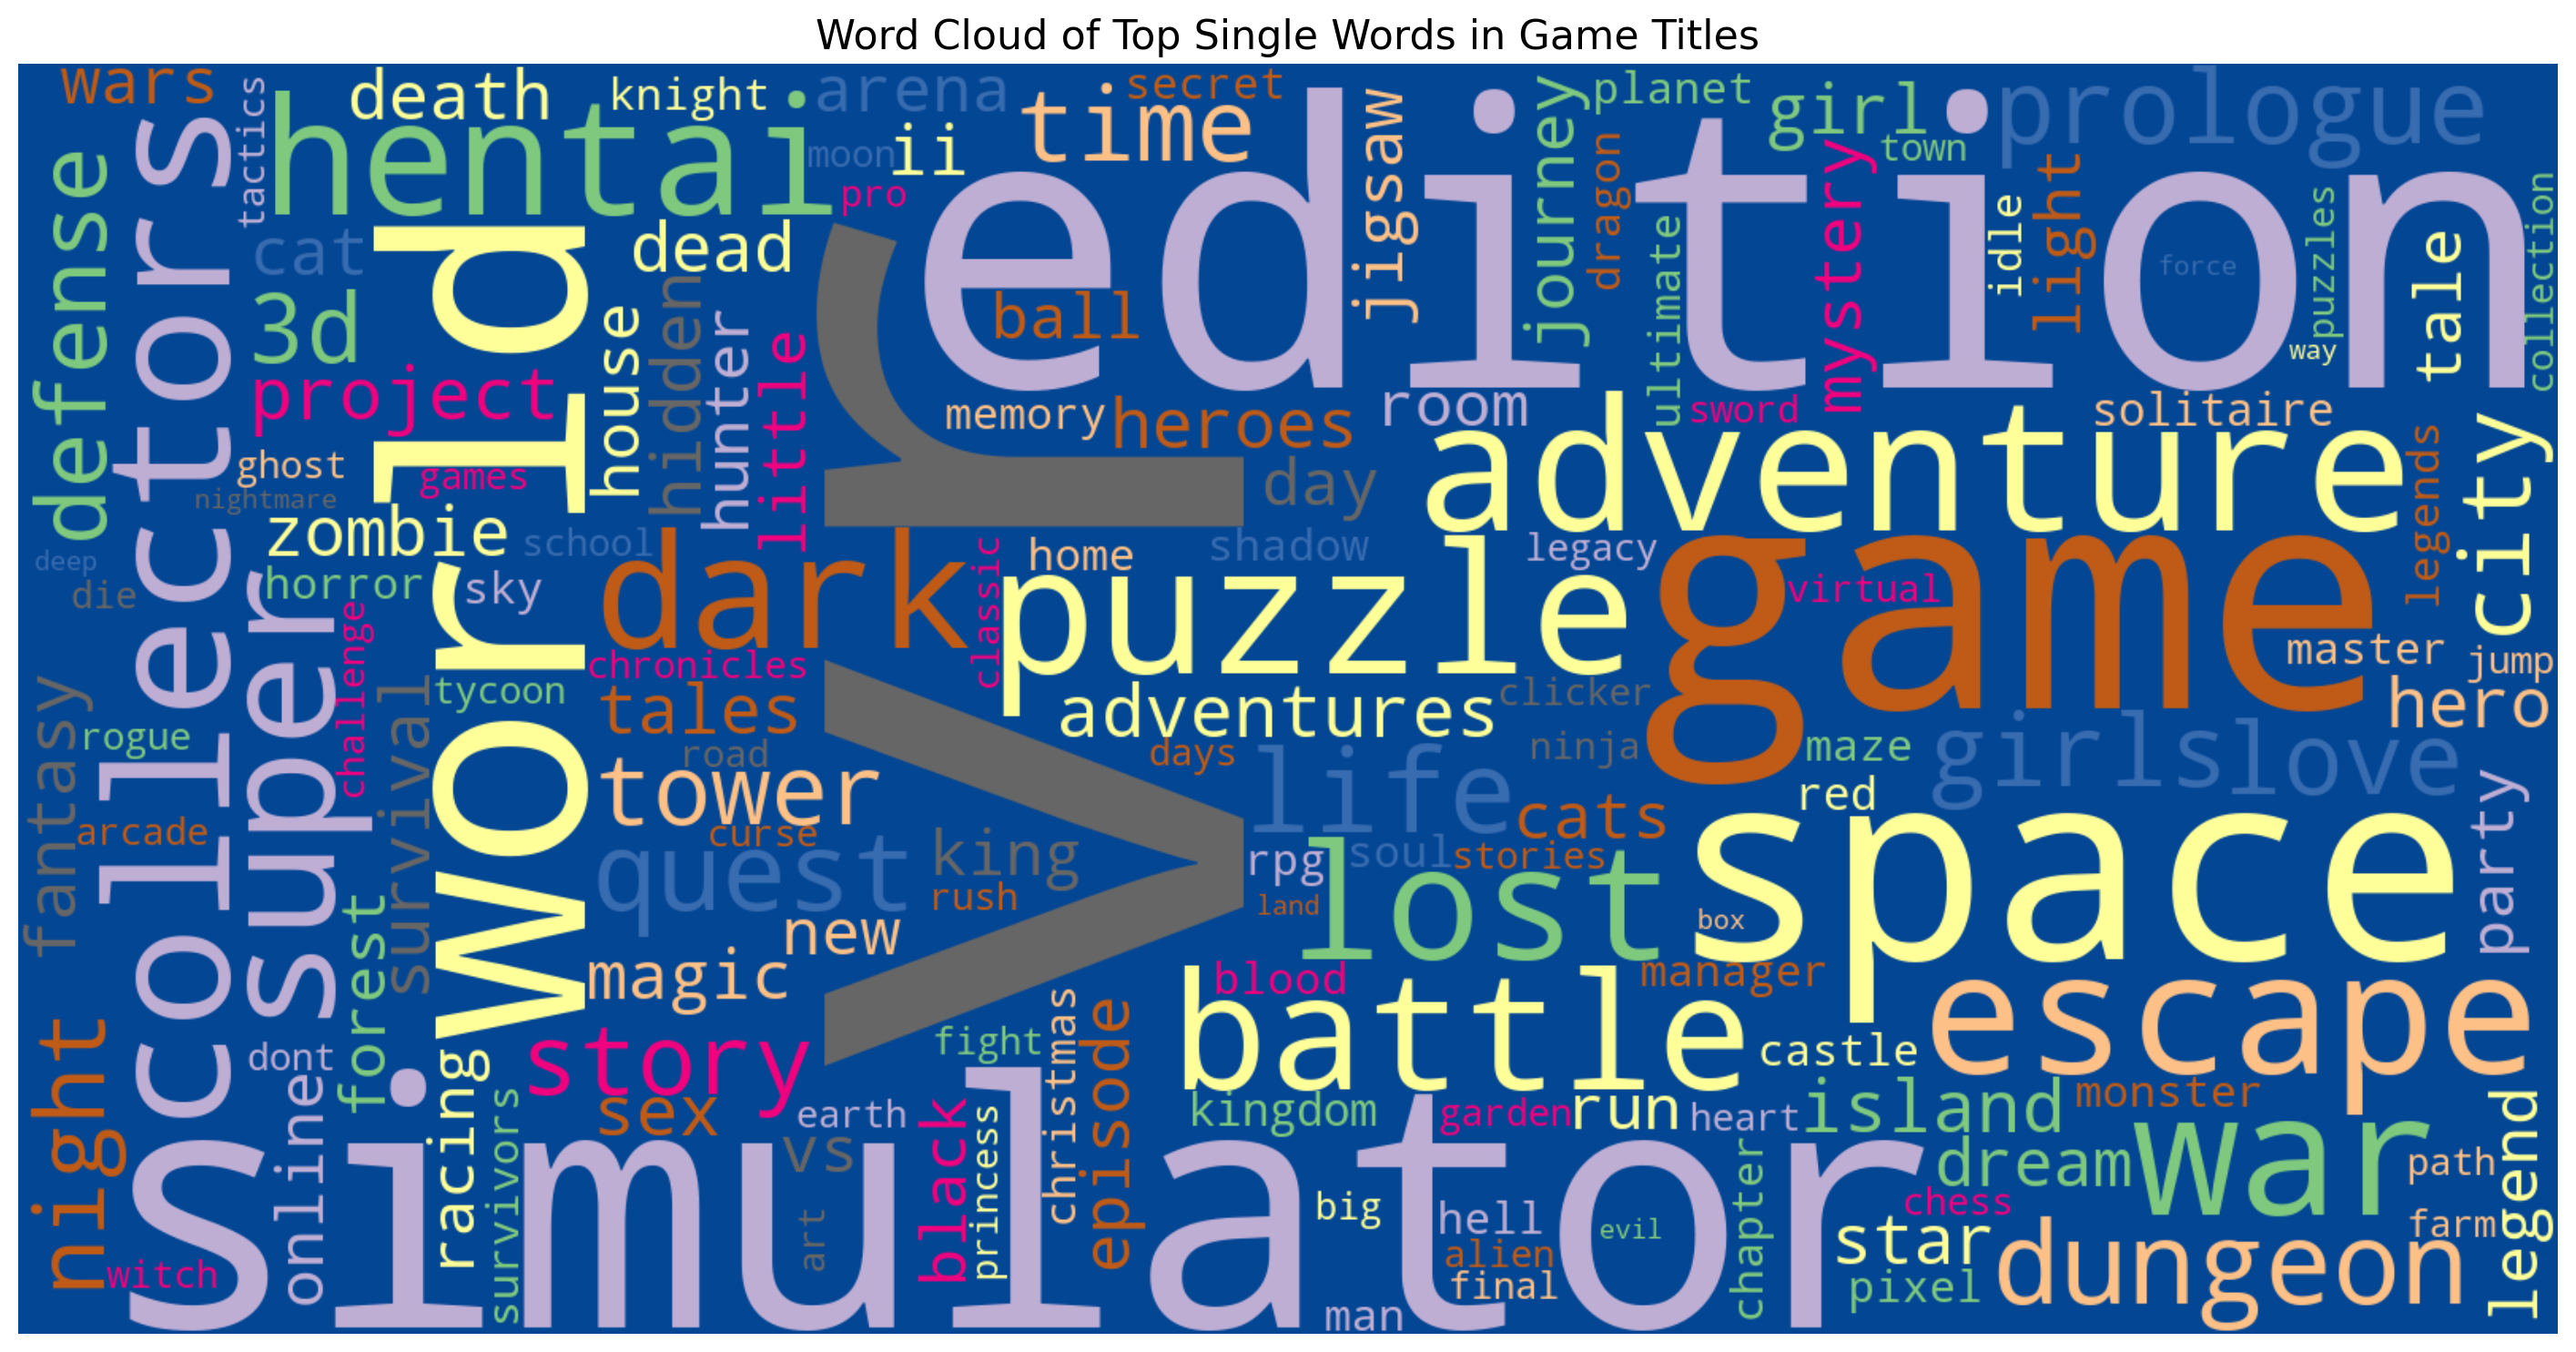

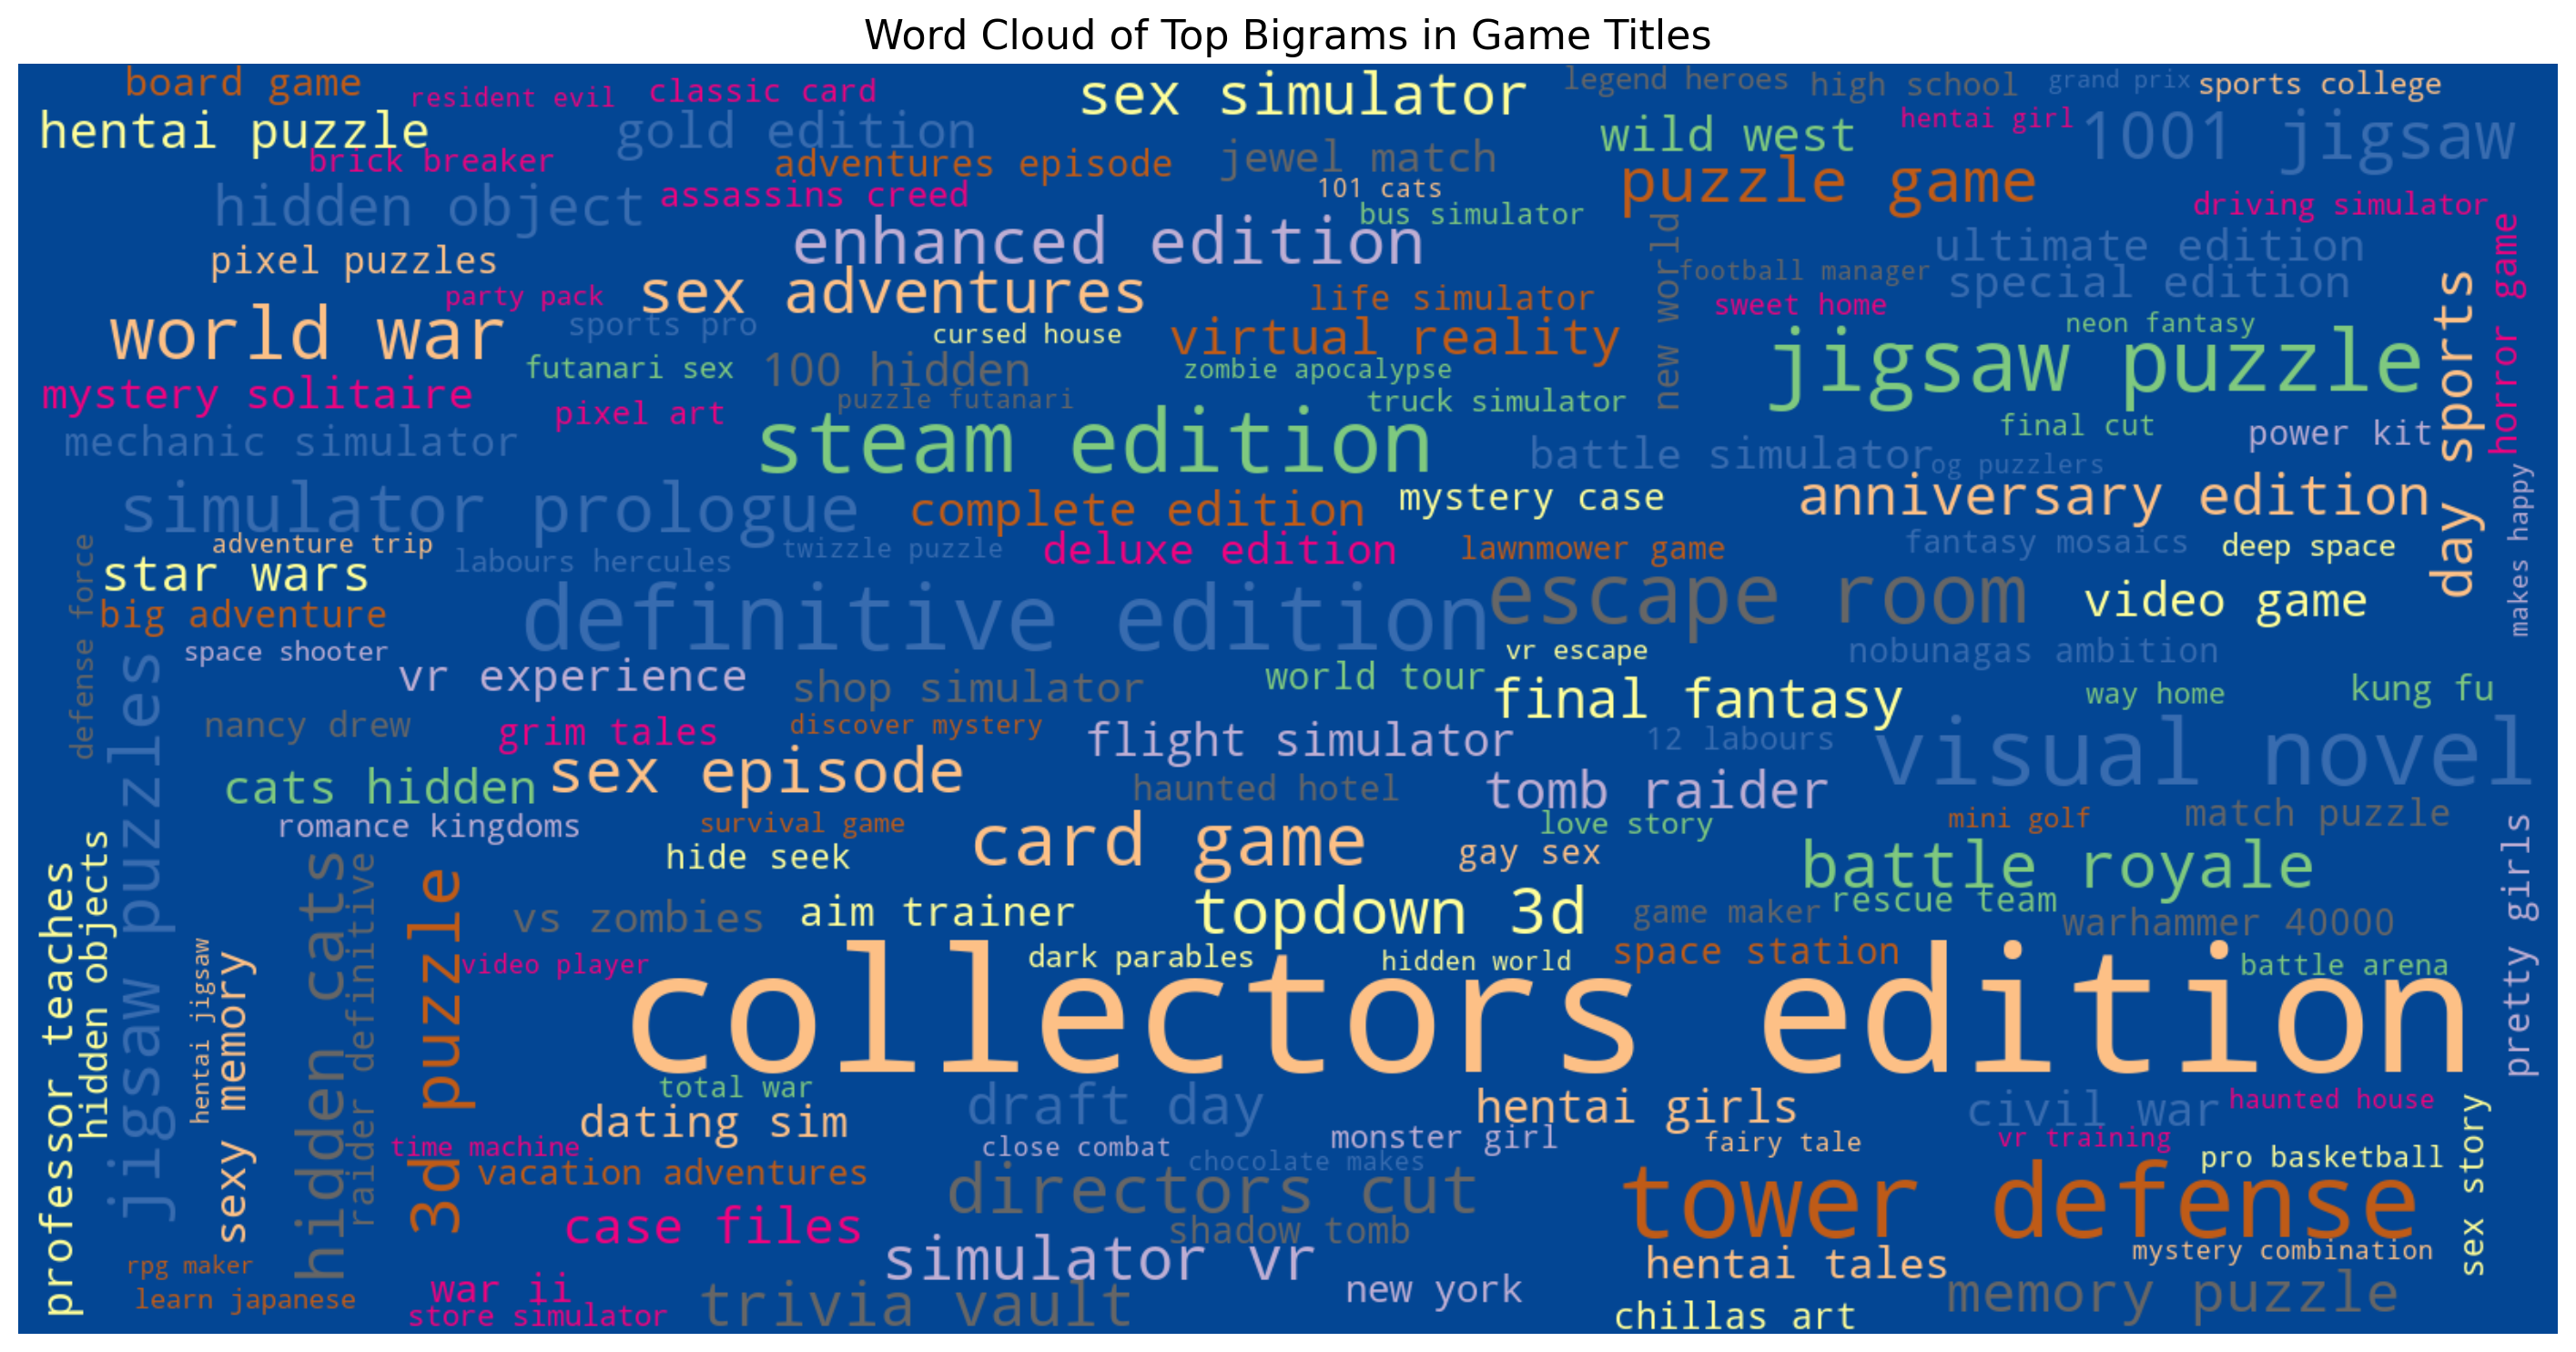

In [28]:
# Most common words in steam game titles
# Single words and bi grams.

def preprocess_titles(titles):
    # Process strings/names for proper analysis by removing non alphanumeric titles, and returning everything as lowercase.
    return titles.str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True)



def get_top_terms(titles, ngram_range=(1,1), top_n=50):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range) # Vectorise results, aka count each rows. Also removed english stop words (words like 'as' etc)
    X = vec.fit_transform(titles) # Transform titles - converts each title into a count of words
    freqs = pd.Series(X.sum(axis=0).A1, index=vec.get_feature_names_out()) # Builds a dataframe of words and their counts.
    return freqs.sort_values(ascending=False).head(top_n).to_dict()



def plot_wordcloud(frequencies, title):
    wc = WordCloud(width=1600, height=800, background_color='#034694', colormap='Accent')
    wc.generate_from_frequencies(frequencies)
    plt.figure(figsize=(18, 12)) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

game_names = preprocess_titles(df['name'].dropna())

# Get top terms, top 150
single_freqs = get_top_terms(game_names, ngram_range=(1,1), top_n=150) # 1 word
bigram_freqs = get_top_terms(game_names, ngram_range=(2,2), top_n=150) # 2 words

# Display results

plot_wordcloud(single_freqs, 'Word Cloud of Top Single Words in Game Titles')
plot_wordcloud(bigram_freqs, 'Word Cloud of Top Bigrams in Game Titles')



## Games released per Year

In [29]:
# Helper functions to plot

# Create a generic plot function that can be reused to keep the same style / colours.

def plot_line(counts, title, xlabel, ylabel, legend=False):  # Set legend to False by default
    plt.figure(figsize=(12, 8))

    # Determine which type of plot to use to control if legend should be shown.

    if hasattr(counts, 'columns'): # Looks at if 'counts' (the value being plotted) has a .columns sttribute. A plot with multiple categories will have the .columns attribute. Single series ones wont, do a legend ownt be added.
        # Add legend for each col (genre / category)
        for col in counts.columns:
            plt.plot(
                counts.index,
                counts[col],
                marker='o',
                linestyle='-',
                markersize=6,
                linewidth=2,
                alpha=0.85,
                label=col
            )
    else:
        # Single‐series plot
        plt.plot(
            counts.index,
            counts.values,
            marker='o',
            linestyle='-',
            markersize=6,
            linewidth=2,
            alpha=0.85
        )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(which='major', linestyle='--', alpha=0.5)
    plt.grid(which='minor', linestyle=':', alpha=0.3)
    plt.tight_layout()

    if legend:
        plt.legend(title='Genre')

    plt.show()

    # Bar plot function

def plot_bar(counts, title, xlabel, ylabel, xlim_min=0,xlim_max=100, fig_height = 12, fig_width= 8):
    plt.figure(figsize=(fig_width, fig_height))
    
    # Determine which type of plot to use to control if legend should be shown.
    if hasattr(counts, 'columns'):
        # Grouped horizontal bar chart for each column
        n_categories = len(counts.columns)
        index = np.arange(len(counts.index))
        bar_height = 0.8 / n_categories
        
        for i, col in enumerate(counts.columns):
            plt.barh(
                index + i * bar_height,
                counts[col],
                height=bar_height,
                alpha=0.85,
                label=col
            )
        # Position y-ticks in the center of grouped bars (the labels on the y axis showing scale)
        plt.yticks(
            index + bar_height * (n_categories - 1) / 2,
            counts.index
        )
    else:
        # Single‐series horizontal bar chart
        plt.barh(
            counts.index,
            counts.values,
            alpha=0.85
        )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()
    ax.set_xlim(xlim_min, xlim_max)   

    # Add vertical grid lines for readability
    plt.grid(axis='x', which='major', linestyle='--', alpha=0.5)
    plt.grid(axis='x', which='minor', linestyle=':', alpha=0.3)
    #plt.tight_layout()
    
    plt.show()



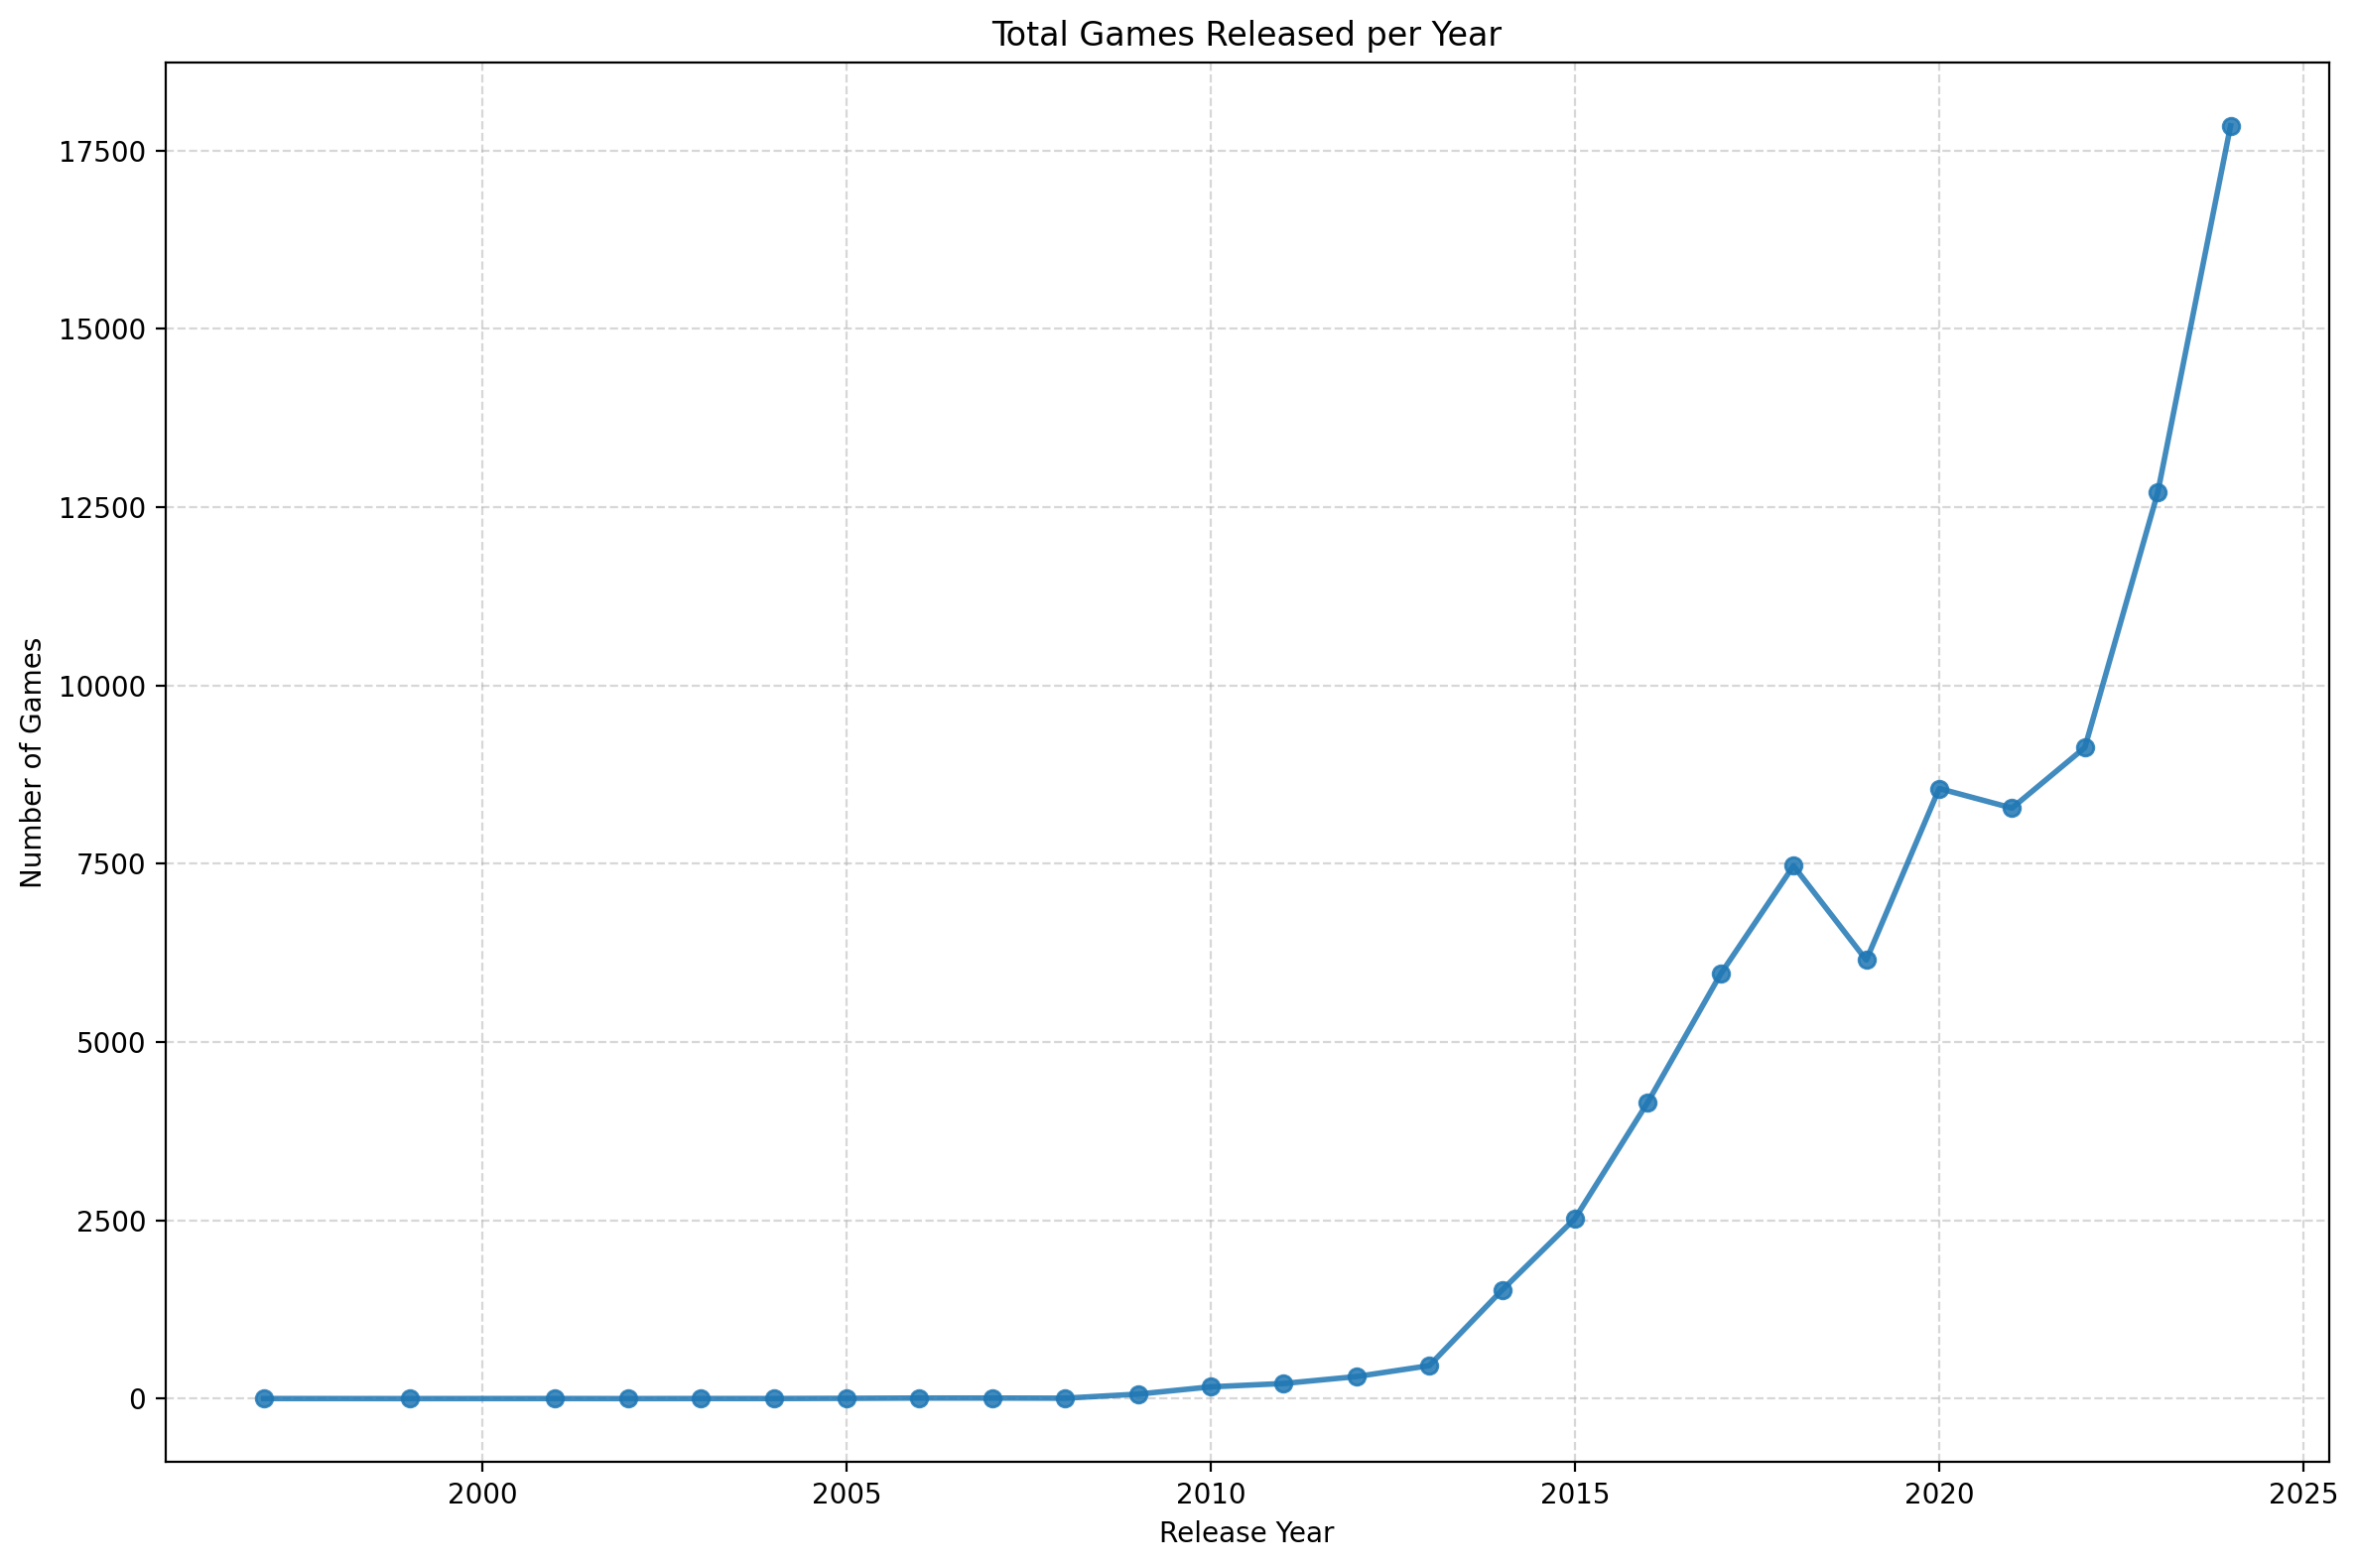

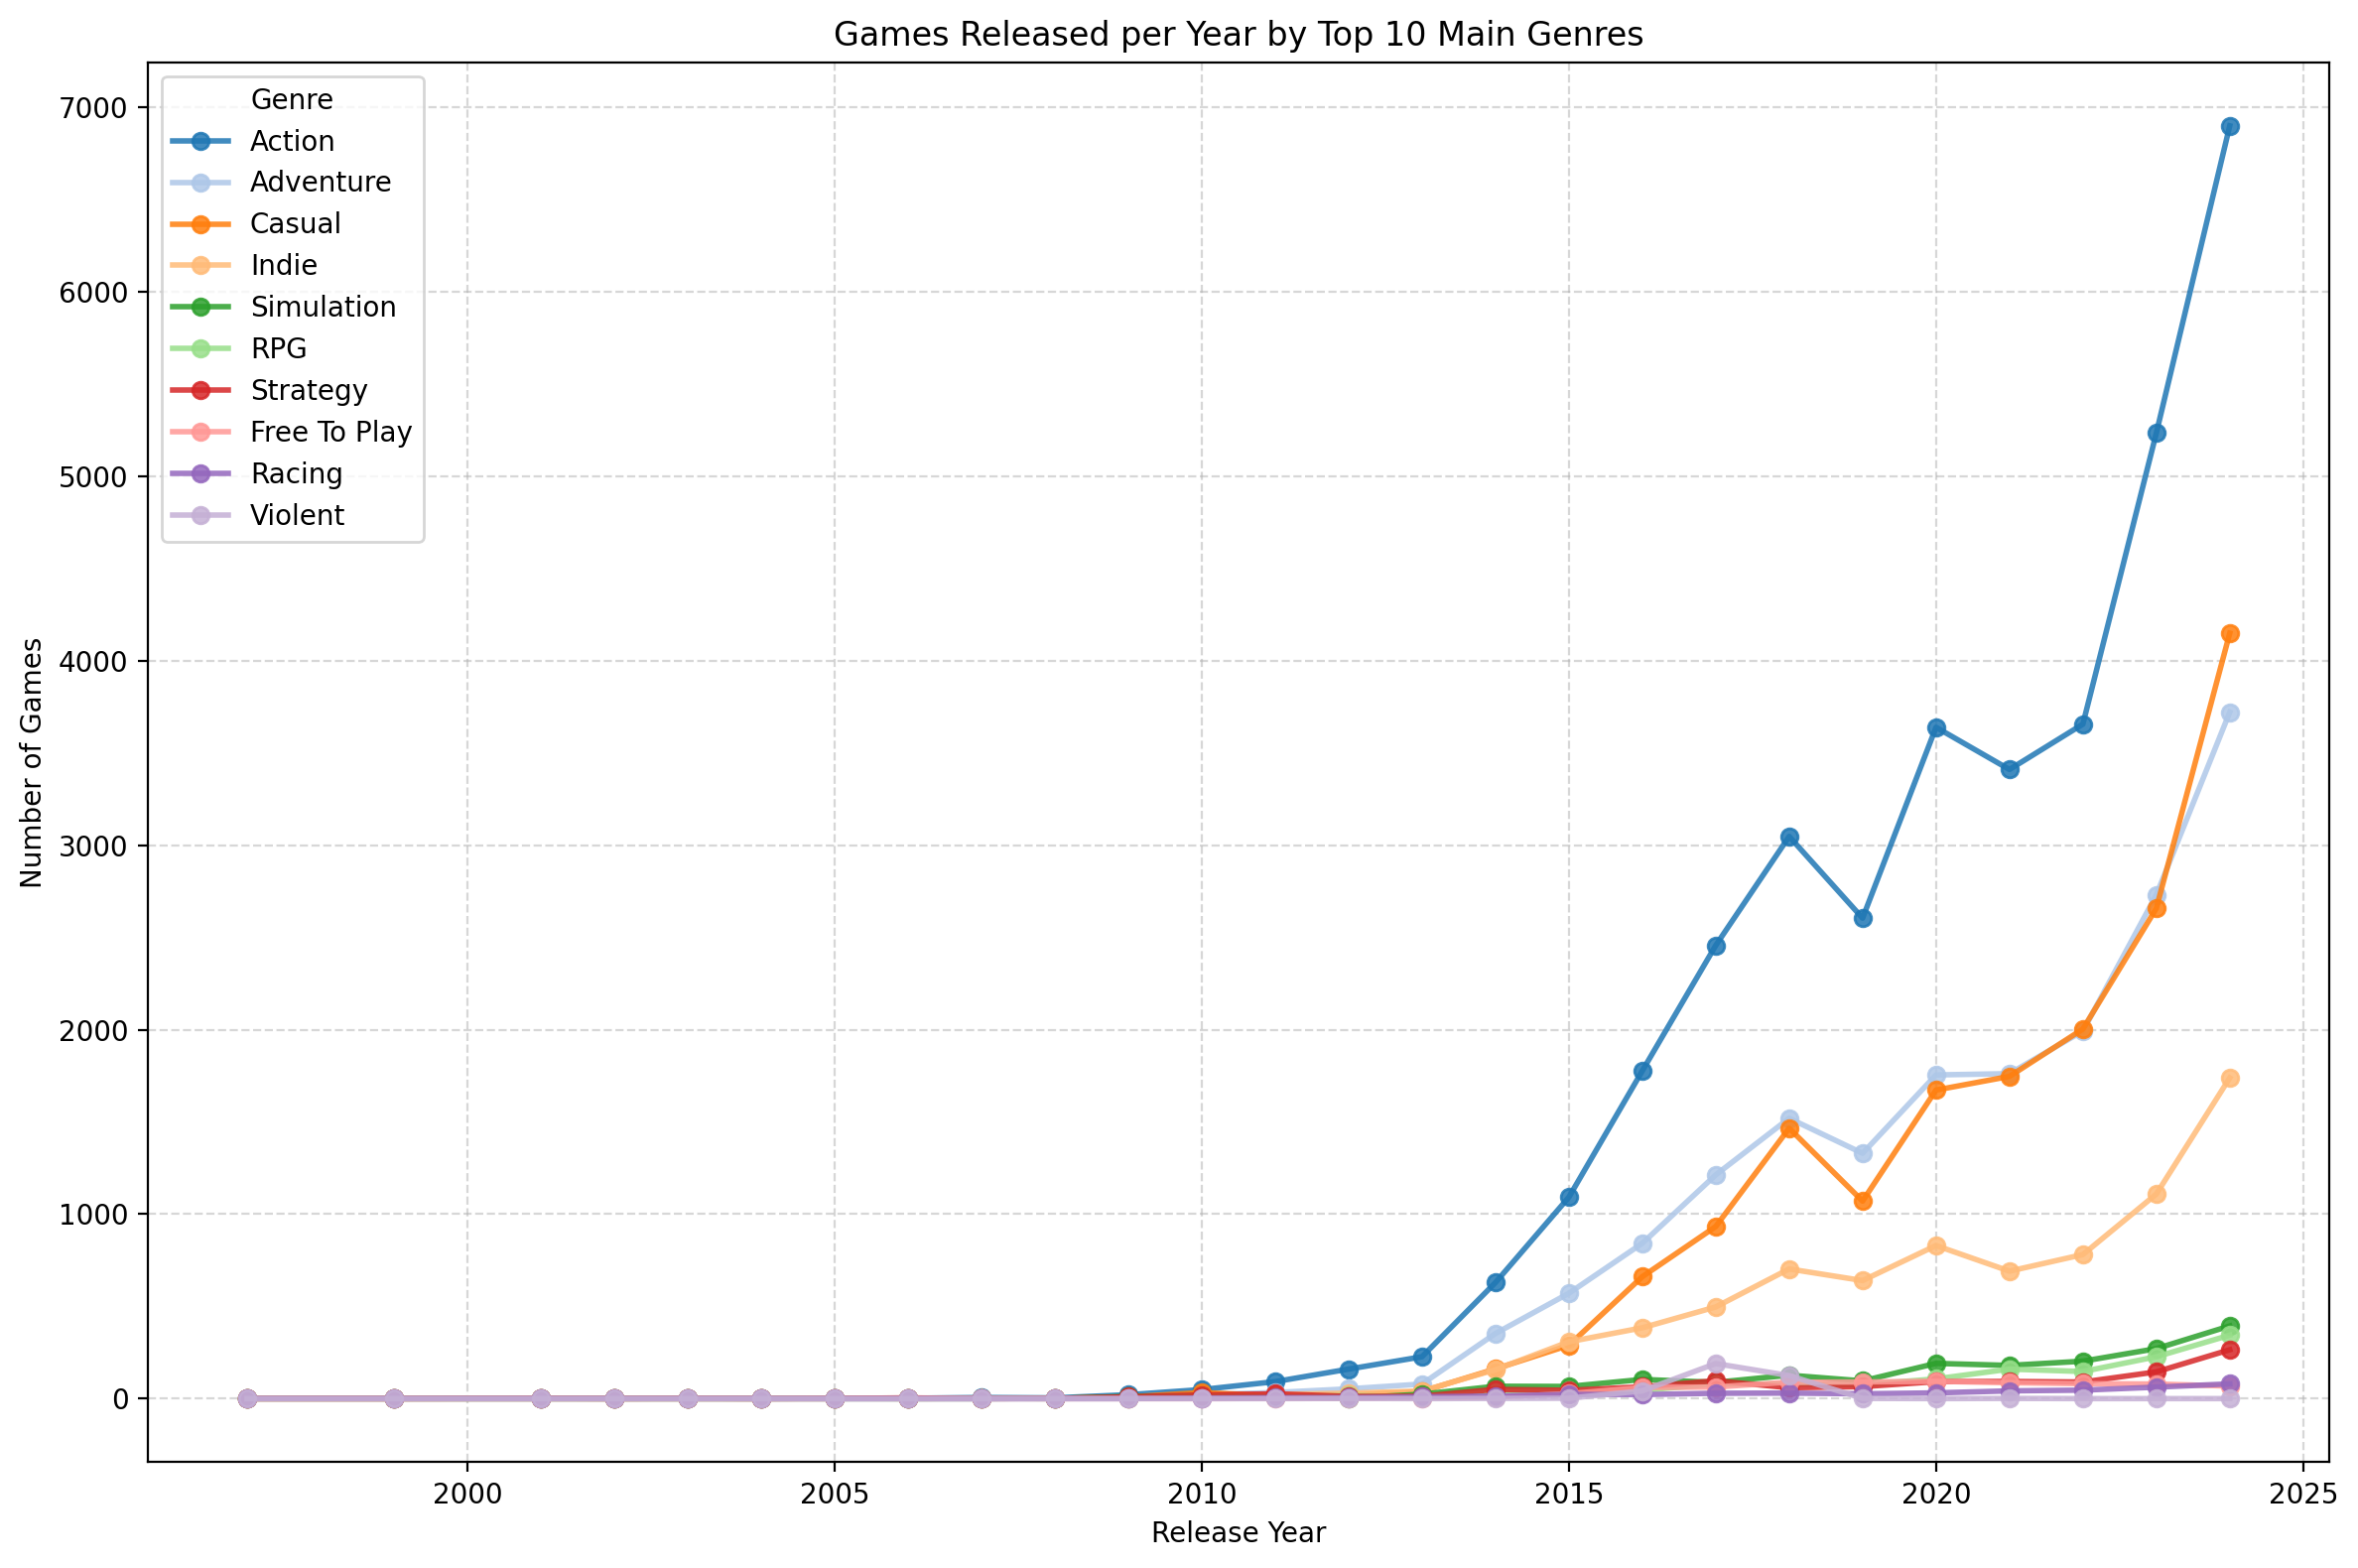

In [30]:
# Plot total games released per year

# Get year into it's own column.
df['year'] = df['release_date'].dt.year

total_counts = df['year'].value_counts().sort_index()
plot_line(total_counts, 'Total Games Released per Year', 'Release Year', 'Number of Games')

# Plot top 10 main genre's over time.
genre_trend = (
    df
    .groupby(['year', 'main_genre']) # Aggregate / group by year and genre
    .size() # Get the count
    .unstack(fill_value=0)
    .sort_index()# Sort by chronological order.
)

top_genres = genre_trend.sum().nlargest(10).index.tolist()
genre_trend_top10 = genre_trend[top_genres]
plot_line(genre_trend_top10, 'Games Released per Year by Top 10 Main Genres', 'Release Year', 'Number of Games', legend=True)


#### Observations:

Casual appears to have surpassed adventure games, with more being released since 2023. Action continues to be the most frequently released game. 

The results of this visual are consistent with the previously made bubble visual, which similarly showed Action to be the dominant genre.

All genres experienced a similar increase of games as the video games industry continued to expand. (Grand View Research, 2020)

## Most and least positively reviewed games

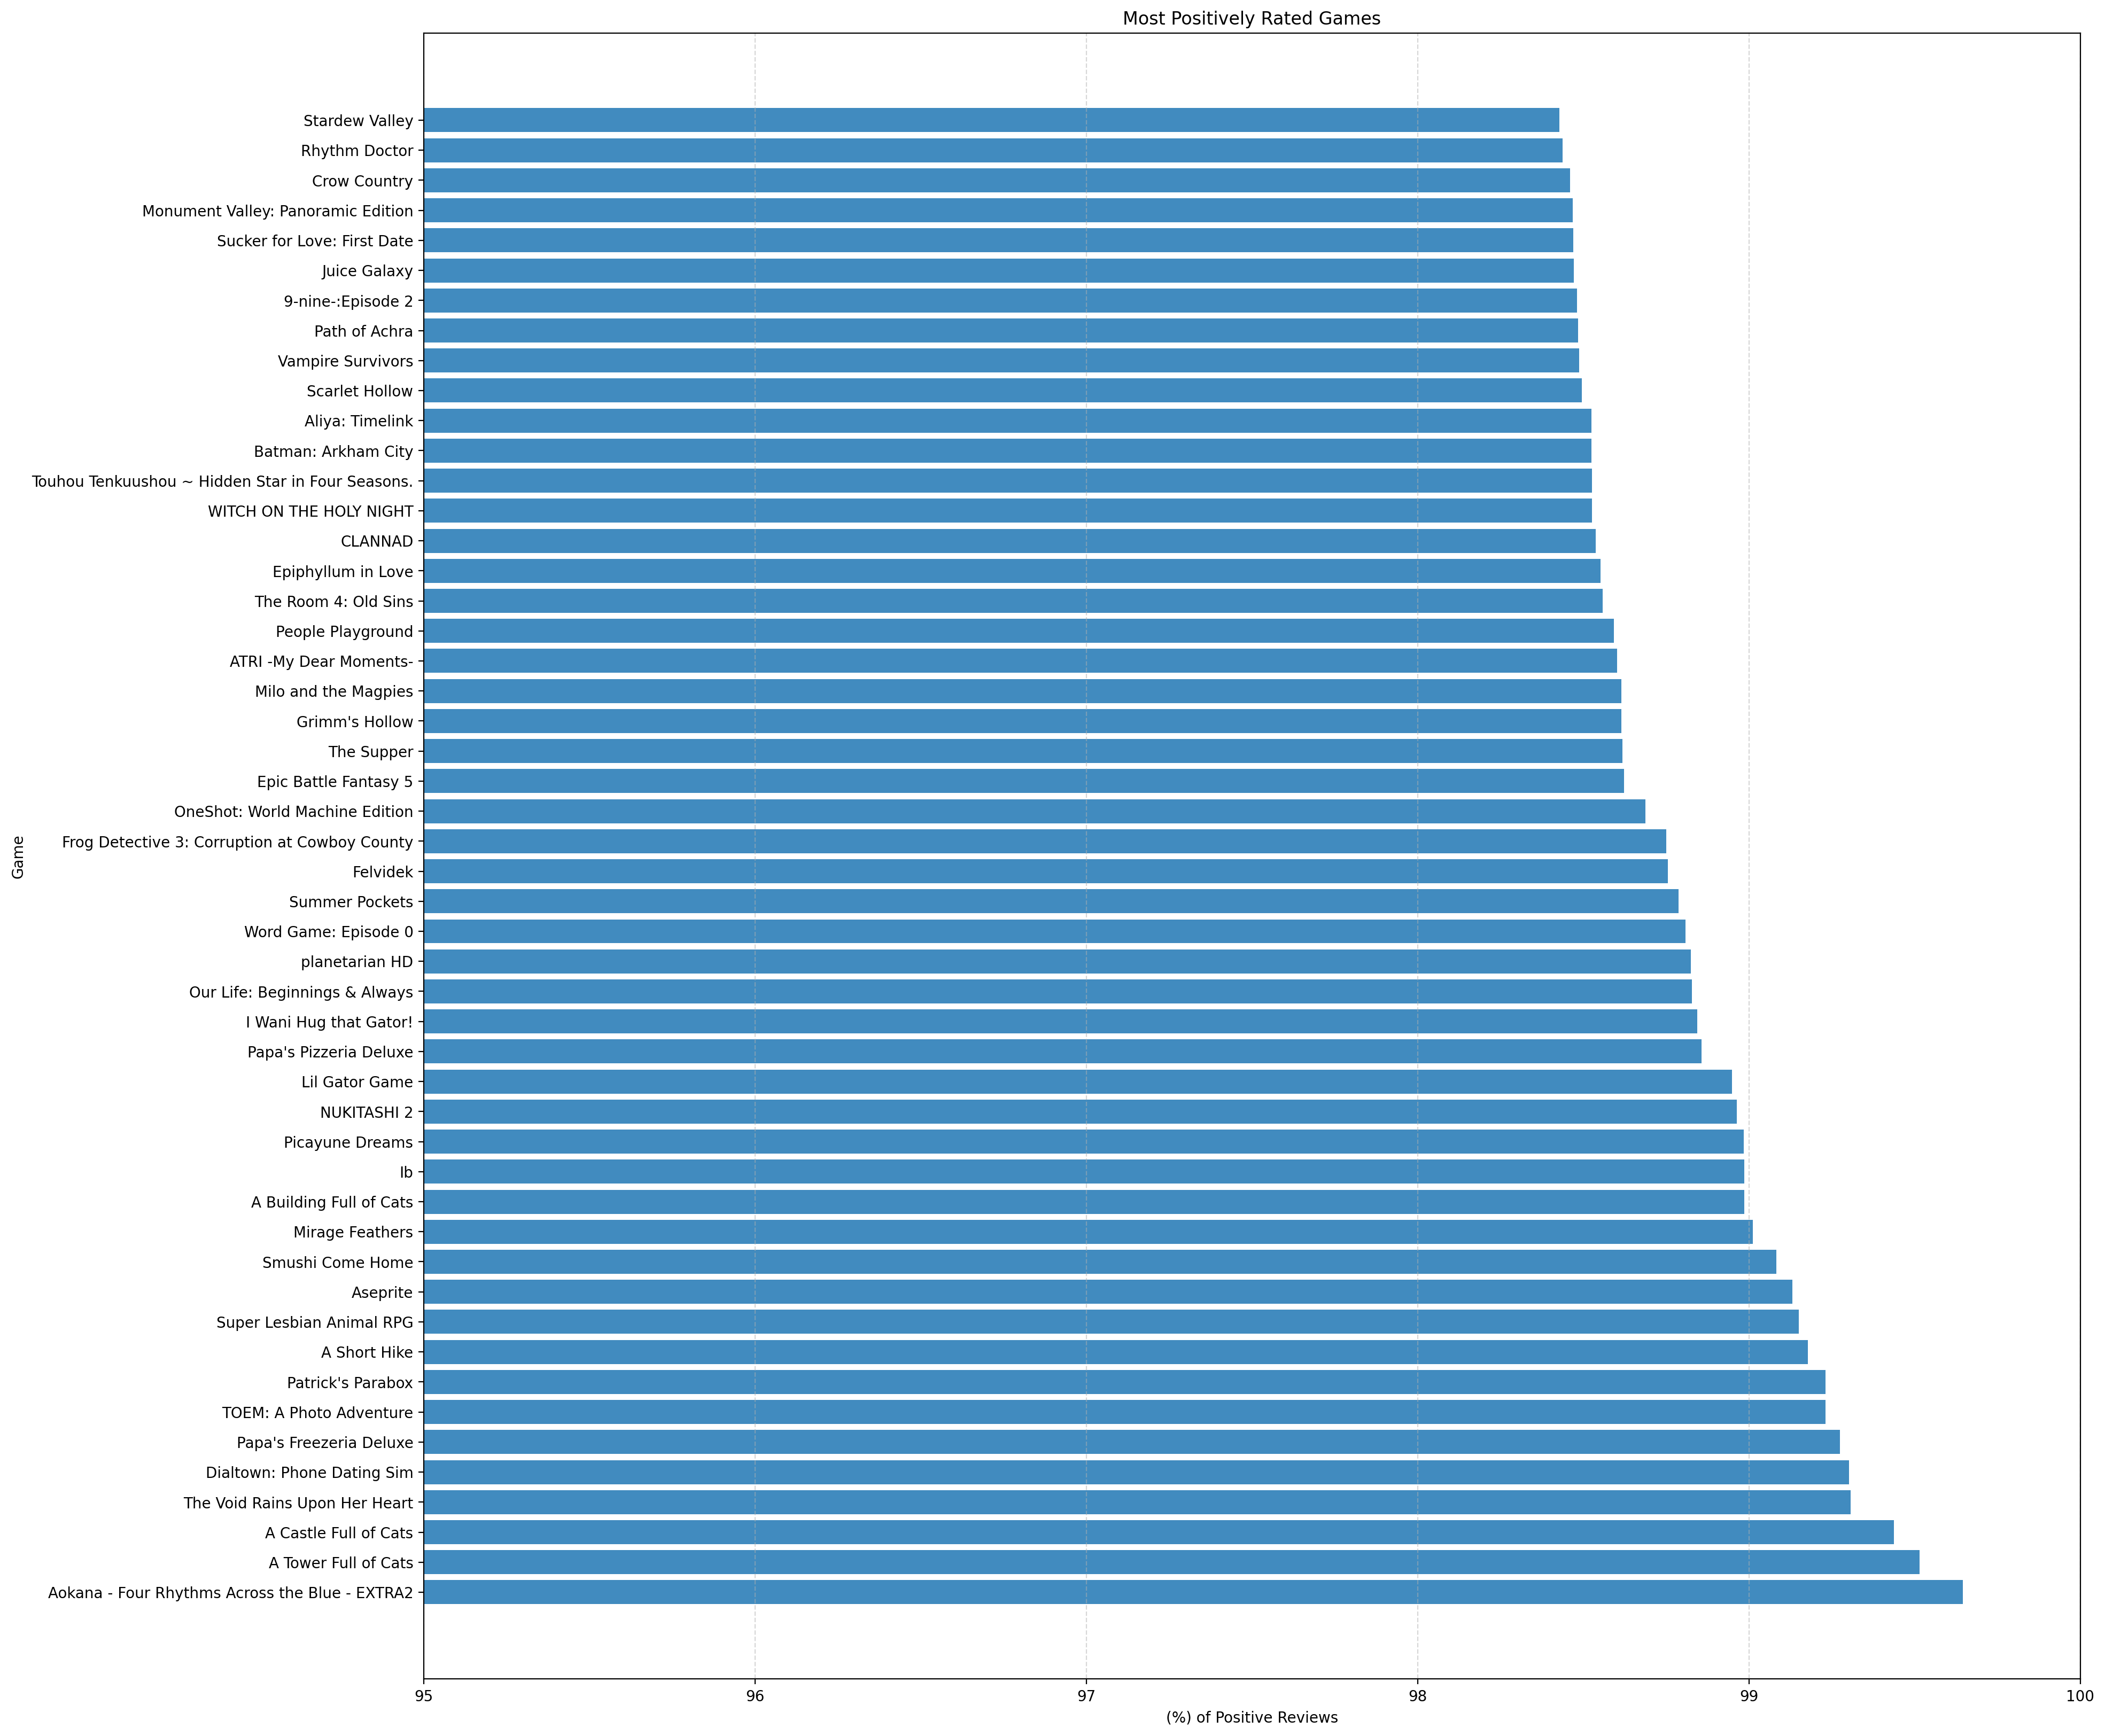

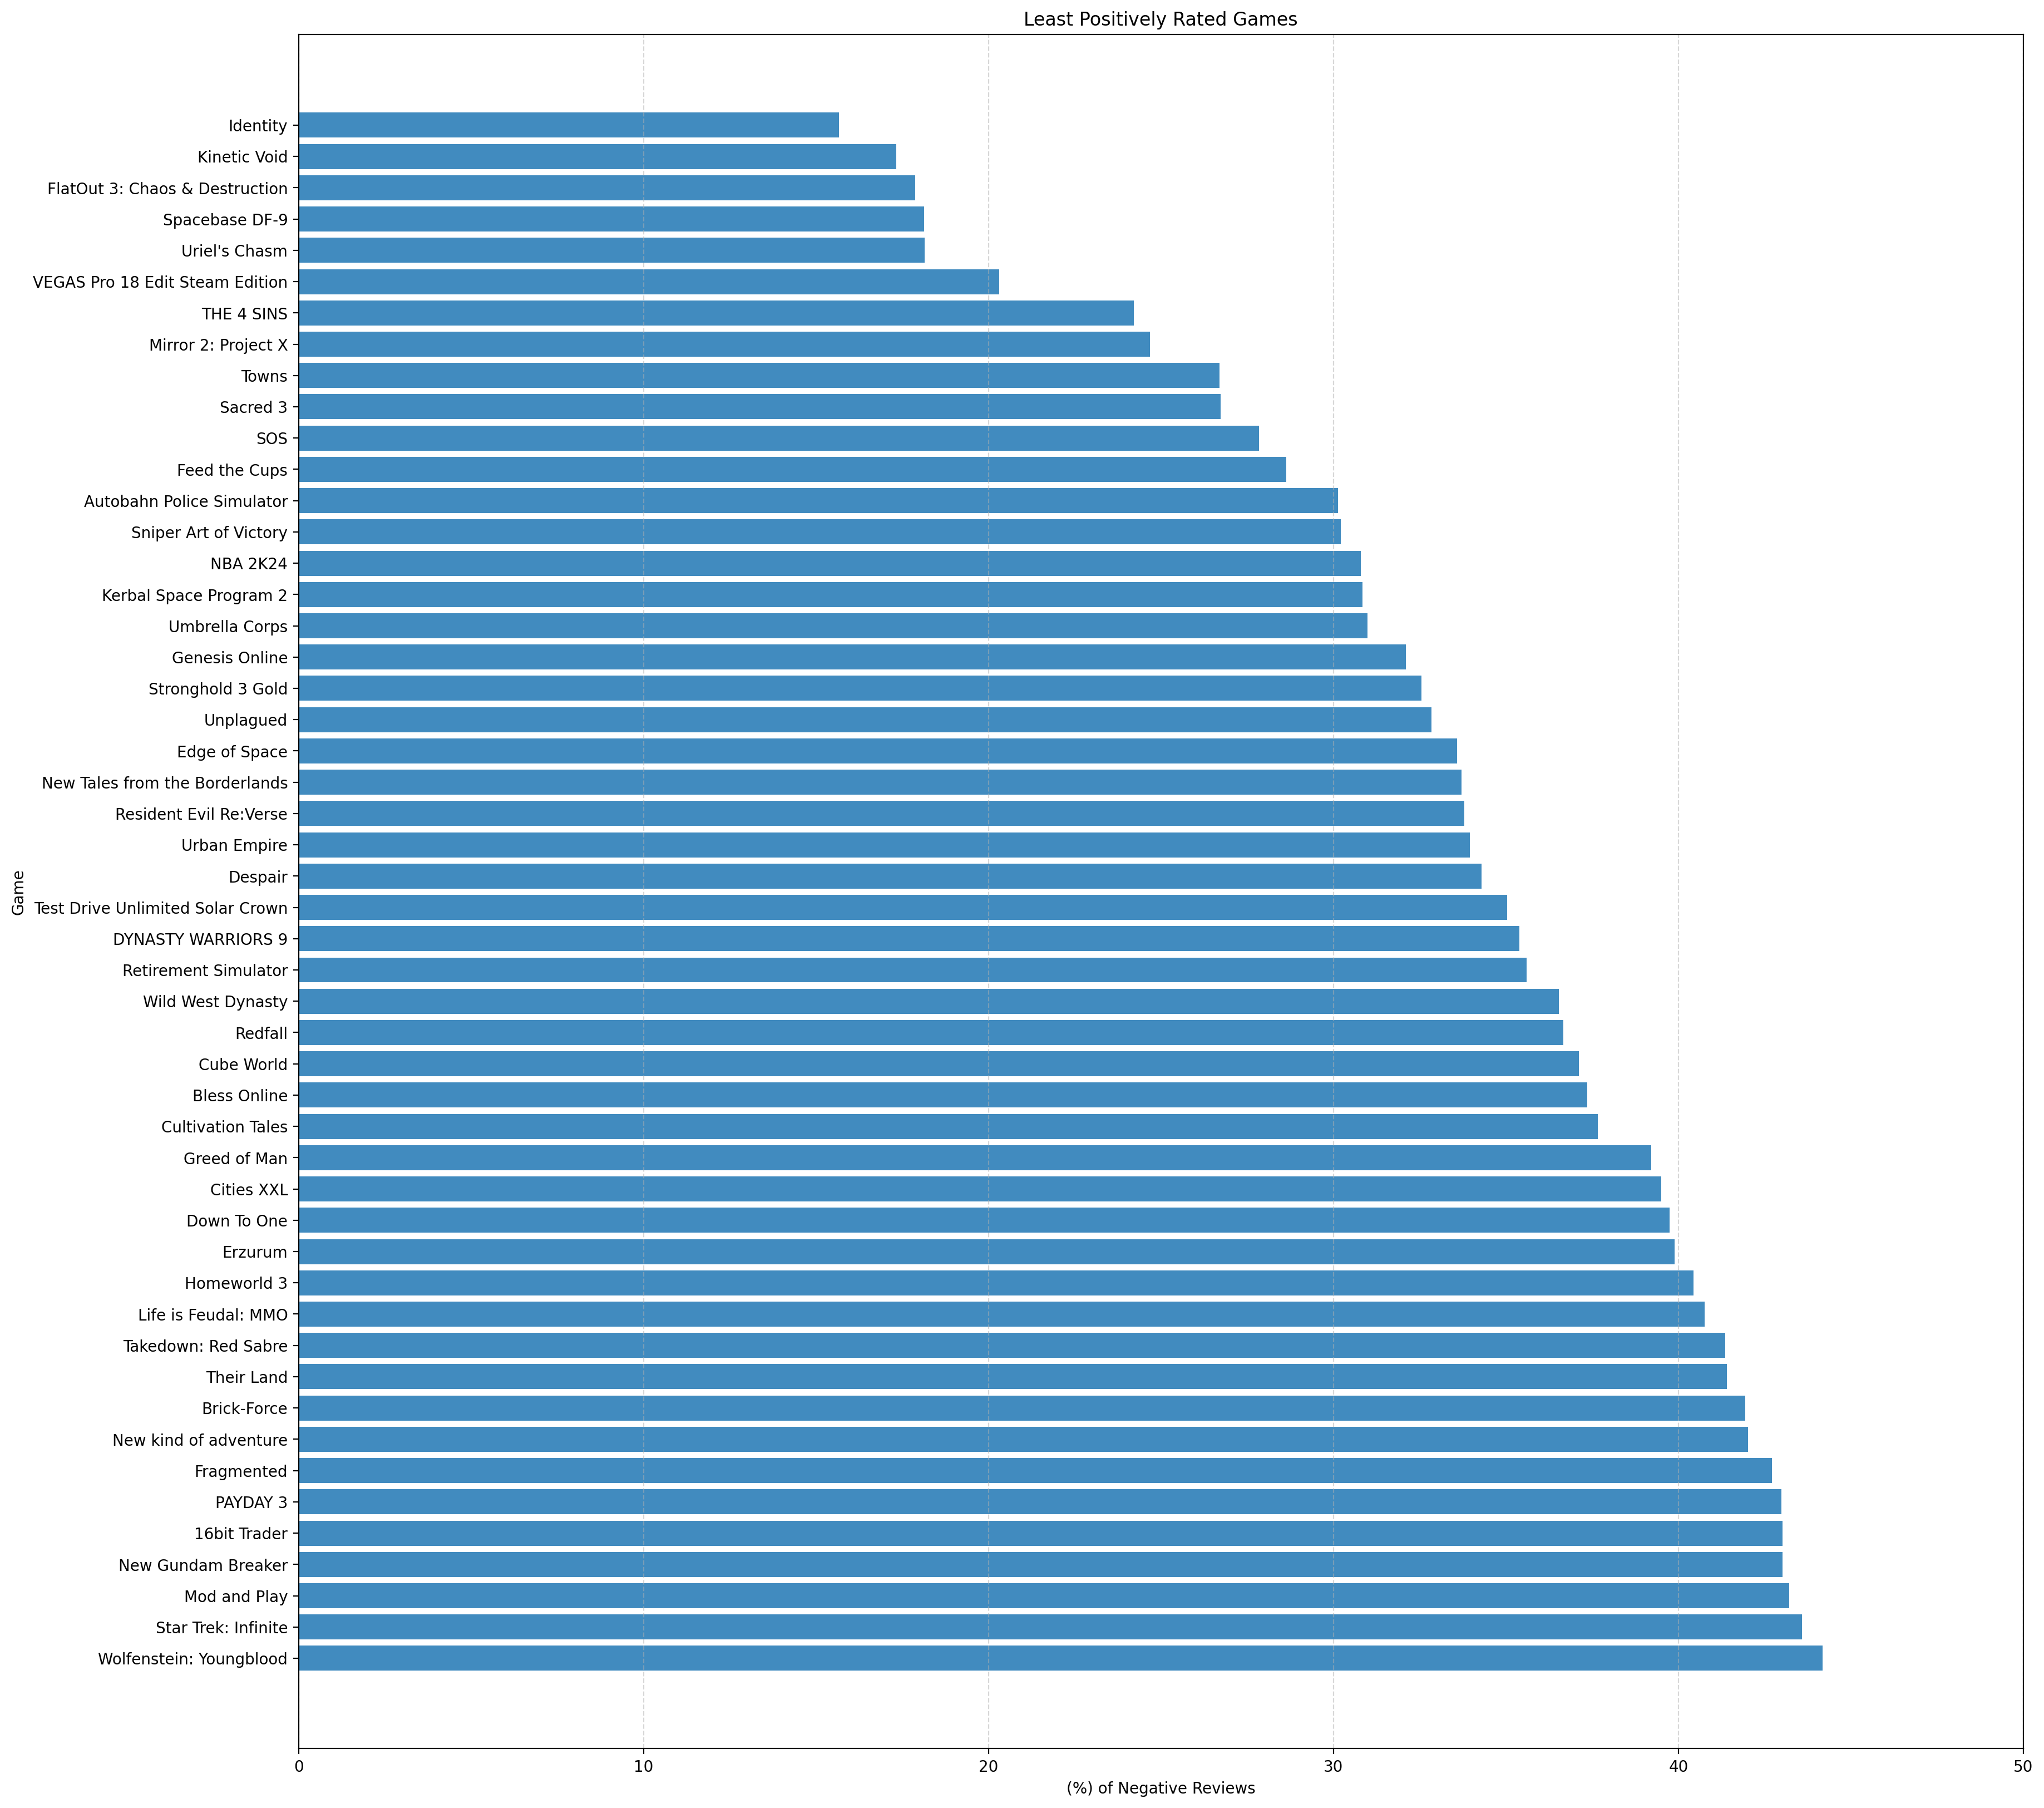

In [31]:
# Filter only to select games with more than 1500 reviews. Helps to avoid showing skewed games with only a handful of reviews, say only 10 total, which may appear at the top of most positive plot. This makes it easier to compare.

df_reviews = df[(df['positive'] + df['negative']) >= 1500]

# Some games dont contain standard english characters which dont visualise well, these will be filtered out.

df_reviews = df_reviews[~df_reviews['name']
    .str.contains(r'[^\x00-\x7F]', regex=True)
]

# Calculate positive review percentage for each game. Take total number of reviews and divide by positive or negative.
df_reviews['positive_pct'] = df_reviews['positive'] / (df_reviews['positive'] + df_reviews['negative']) * 100

# Positive:
most_positive = (
    df_reviews
    .sort_values('positive_pct', ascending=False)
    .set_index('name')['positive_pct']
    .head(50)
)

# Negative:
least_positive = (
    df_reviews
    .sort_values('positive_pct', ascending=False)
    .set_index('name')['positive_pct']
    .tail(50)
)

# Plot positive:
plot_bar(
    most_positive,
    'Most Positively Rated Games',
    '(%) of Positive Reviews',
    'Game',
    xlim_min= 95, xlim_max= 100 ,# Focus plot ontop 5% to show differences more clearly.
    fig_width = 20, fig_height = 20
)

# Plot negative:
plot_bar(
    least_positive,
    'Least Positively Rated Games',
    '(%) of Negative Reviews',
    'Game', xlim_min= 0, xlim_max= 50 ,
    fig_width = 20, fig_height = 20
)


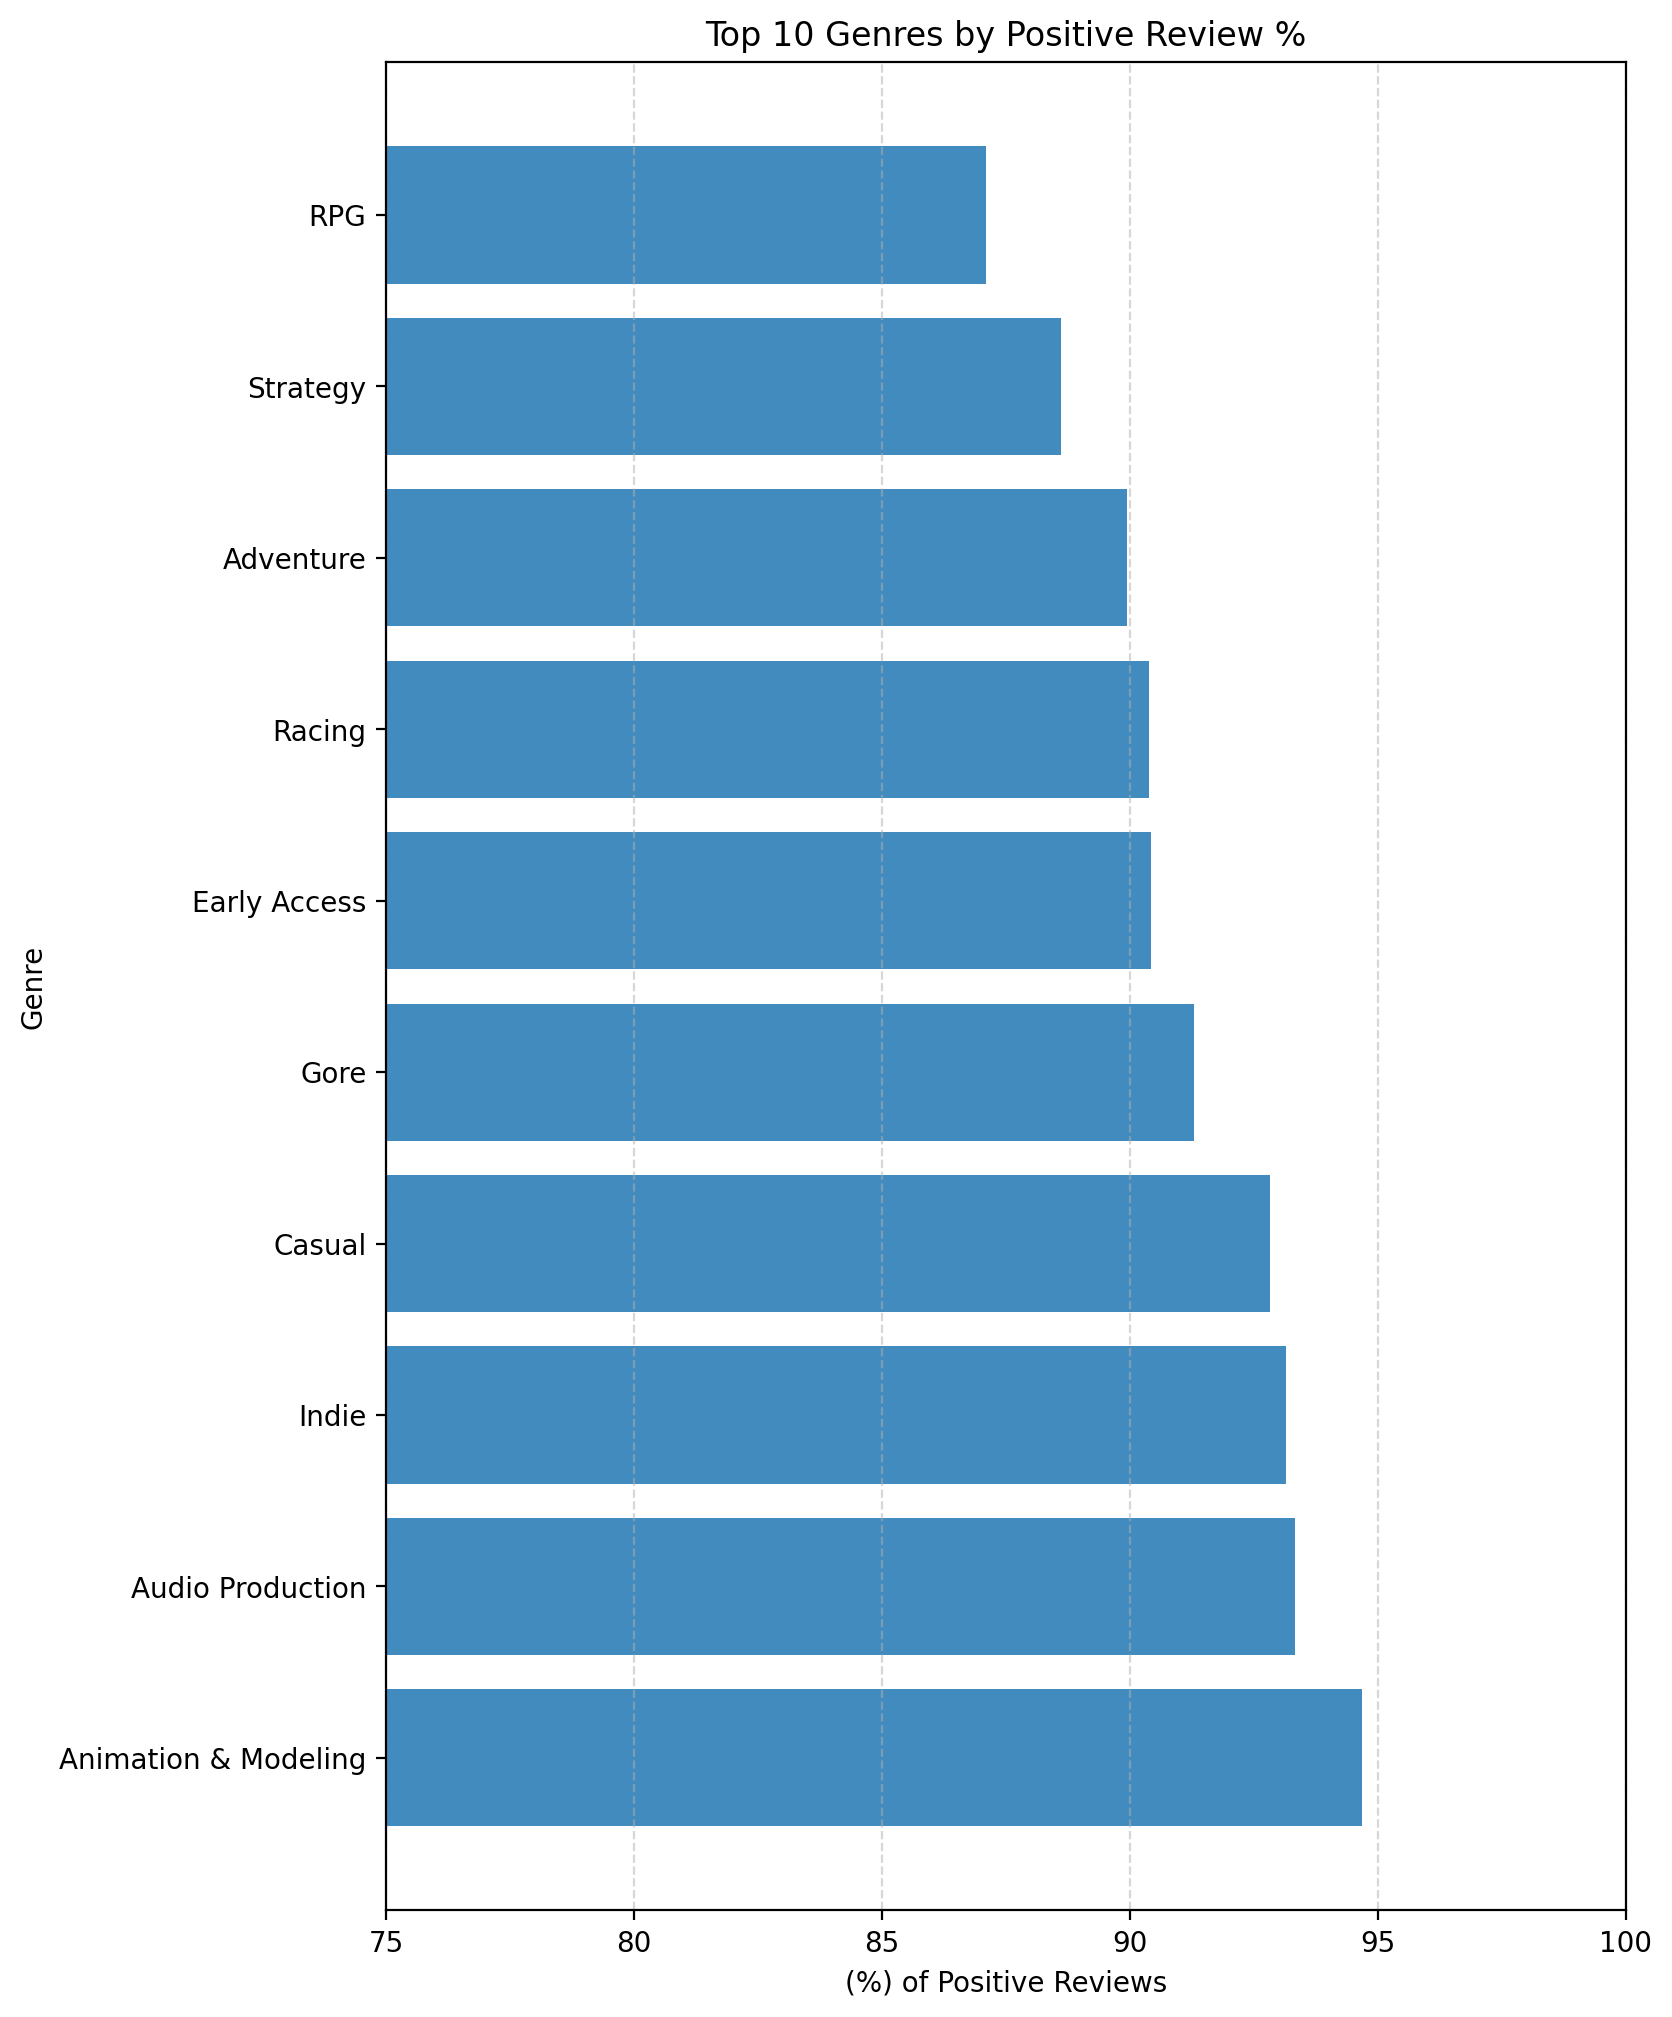

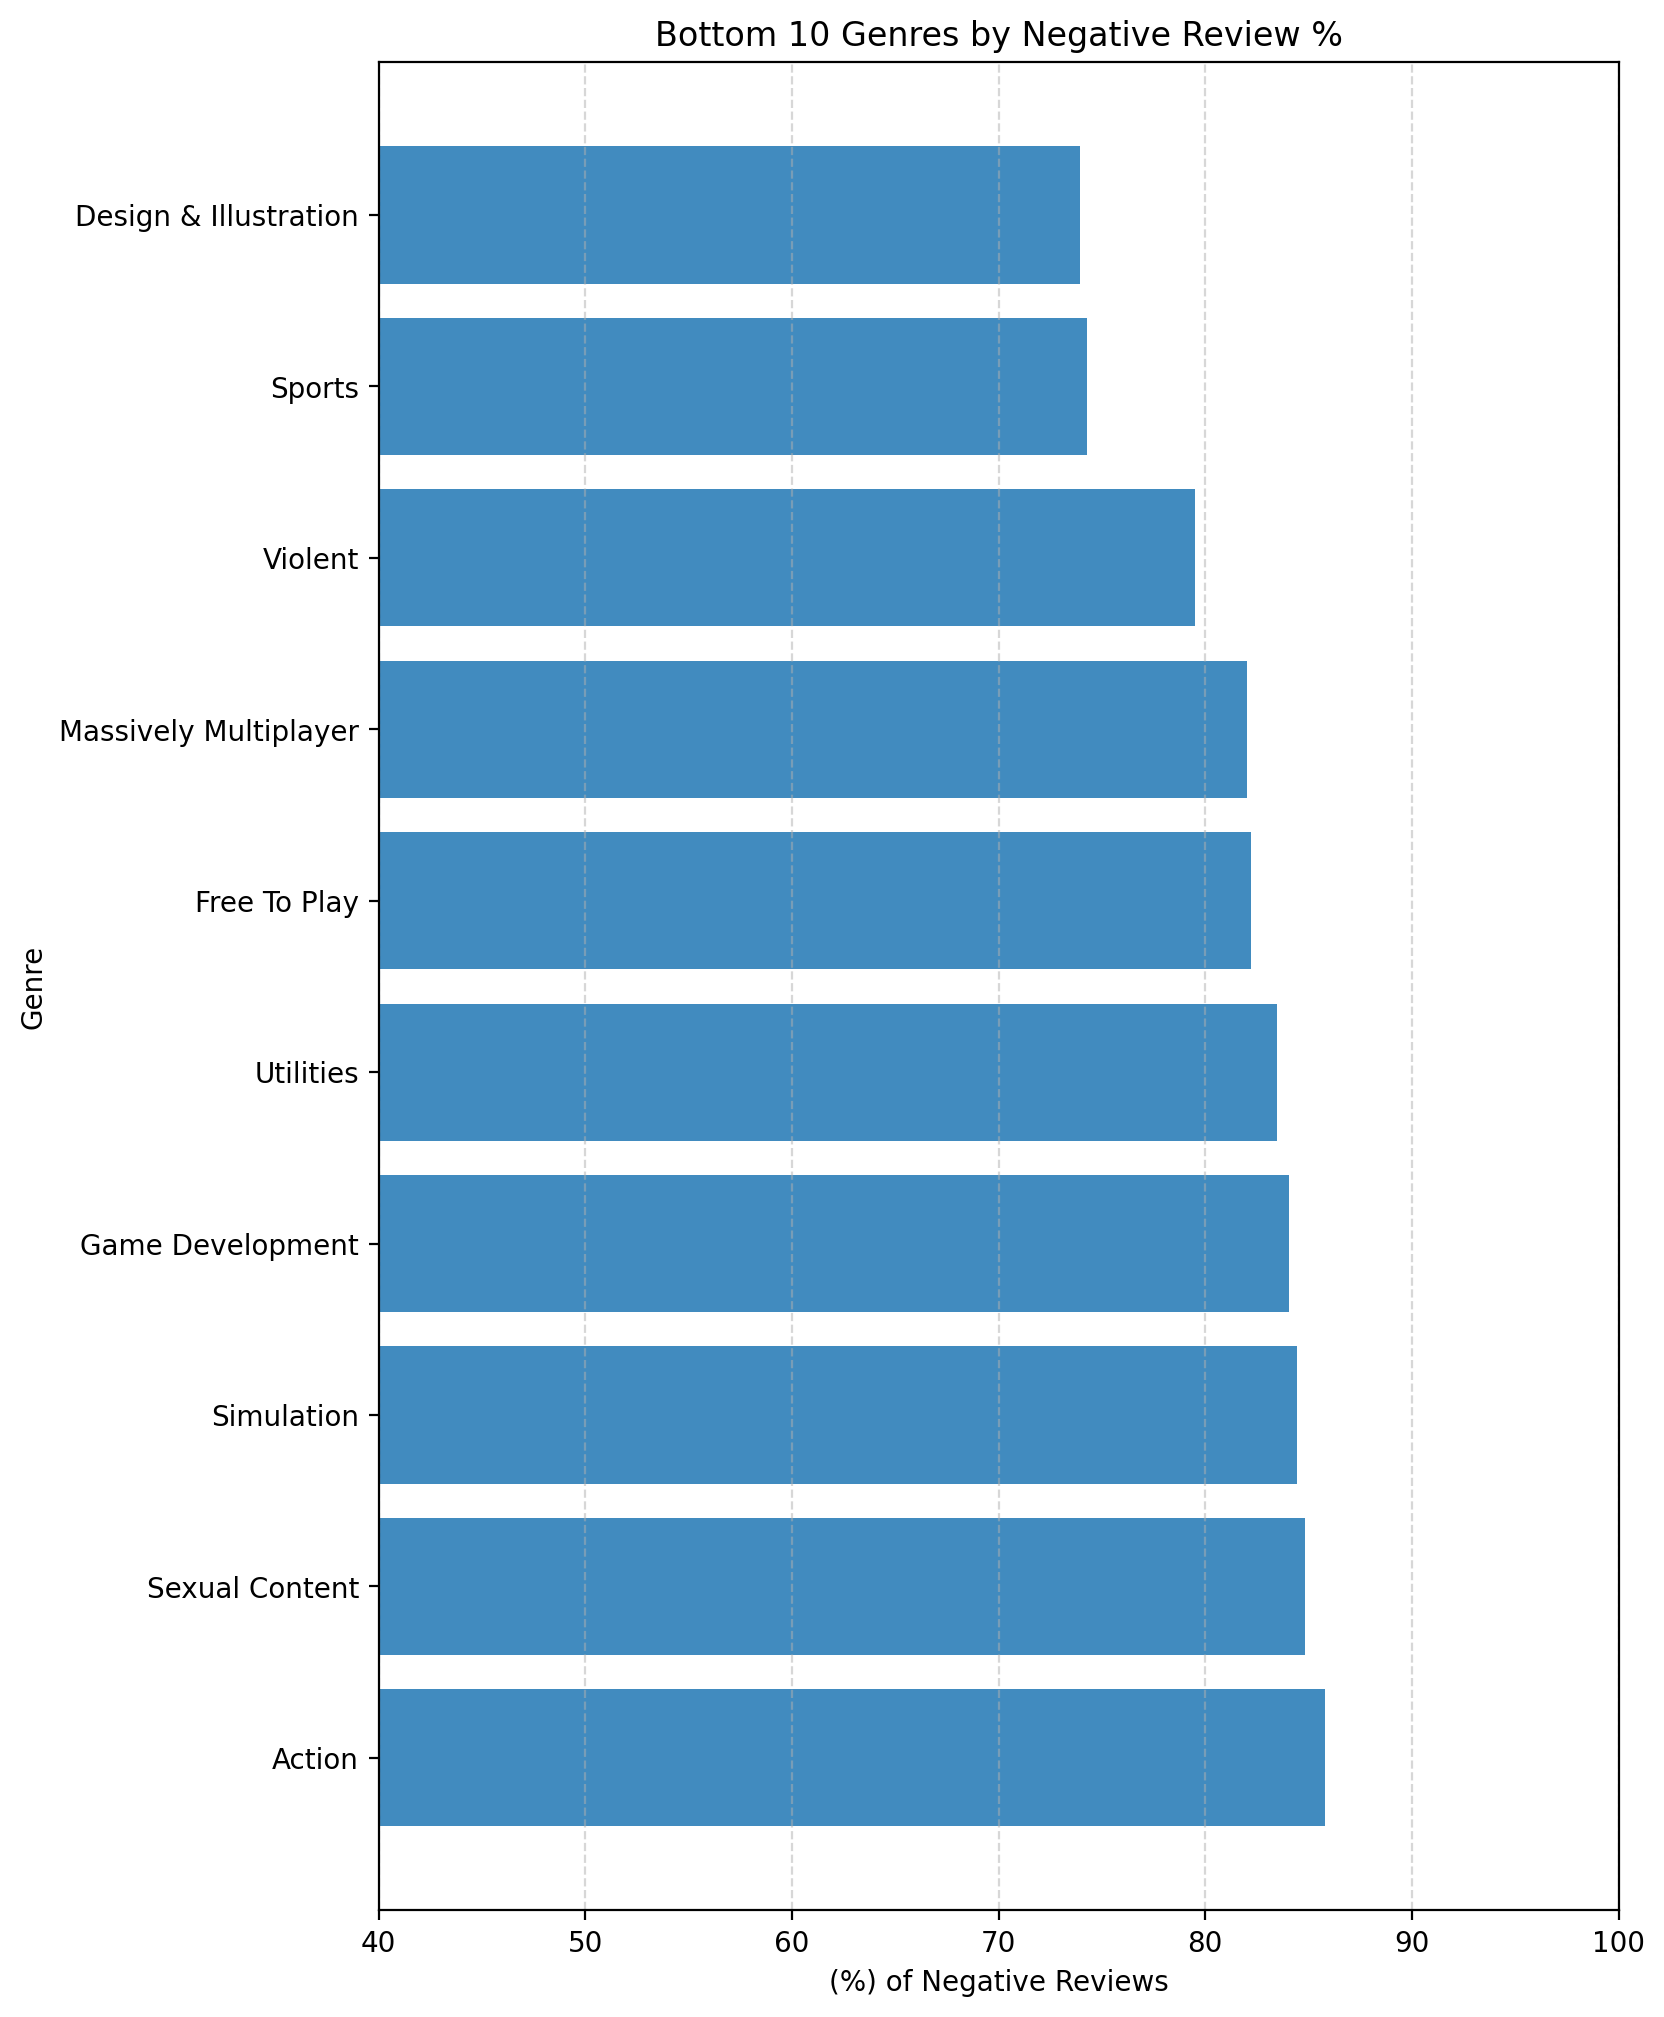

In [32]:
# Plot reviews per genre instead of game. This could yield valuable insights when performing machine learning, informing the tool if one genre has stronger predictive power based on differences in reviews.

# Aggregate positive and begative reviews, this time by genre.
genre_agg = (
    df_reviews
    .groupby('main_genre')[['positive', 'negative']]
    .sum()
)


# Get positive-review percentage per genre
genre_agg['positive_pct'] = (
    genre_agg['positive']
    / (genre_agg['positive'] + genre_agg['negative'])
    * 100
)

# Prepare data to plot:
most_pos_genre = (
    genre_agg
    .sort_values('positive_pct', ascending=False)
    ['positive_pct']
    .head(10)    # top 10 genres
)

least_pos_genre = (
    genre_agg
    .sort_values('positive_pct', ascending=False)
    ['positive_pct']
    .tail(10)    # bottom 10 genres
)

# Plot
plot_bar(
    most_pos_genre,
    'Top 10 Genres by Positive Review %',
    '(%) of Positive Reviews',
    'Genre',
    xlim_min=75,
    xlim_max=100,
)

plot_bar(
    least_pos_genre,
    'Bottom 10 Genres by Negative Review %',
    '(%) of Negative Reviews',
    'Genre',
    xlim_min=40,
    xlim_max=100
)


#### Observations:

Despite being the most popular genre, Action has a lower review % at ~85%. This may be due to the sheer volume of players this genre receives impacting results. 

The data will be printed below to display and confirm this by looking at the estimated owners per genre.

In [33]:
# Aggregate positive and begative reviews, this time by genre as well as estimated owners.
genre_summary = (
    df_reviews
    .groupby('main_genre')[['positive', 'negative','estimated_owners']]
    .sum()
)


# Calculate percentages
genre_summary['total'] = genre_summary['positive'] + genre_summary['negative']
genre_summary['positive_pct'] = genre_summary['positive'] / genre_summary['total'] * 100
genre_summary['negative_pct'] = 100 - genre_summary['positive_pct']

# Select and sort columns for display
display_summary = (
    genre_summary
    [['positive_pct','negative_pct','estimated_owners']]
    .sort_values('estimated_owners', ascending=False)
)
# Format estimated owners with commas.
display_summary['estimated_owners'] = display_summary['estimated_owners'].map("{:,}".format)

# Print as markdown table
print(display_summary.to_markdown(floatfmt=".2f"))


| main_genre            |   positive_pct |   negative_pct | estimated_owners   |
|:----------------------|---------------:|---------------:|:-------------------|
| Action                |          85.79 |          14.21 | 4,171,985,000      |
| Adventure             |          89.94 |          10.06 | 659,040,000        |
| Indie                 |          93.14 |           6.86 | 347,540,000        |
| Casual                |          92.82 |           7.18 | 336,570,000        |
| RPG                   |          87.10 |          12.90 | 196,995,000        |
| Simulation            |          84.44 |          15.56 | 167,650,000        |
| Strategy              |          88.61 |          11.39 | 97,955,000         |
| Racing                |          90.39 |           9.61 | 44,050,000         |
| Free To Play          |          82.21 |          17.79 | 39,950,000         |
| Massively Multiplayer |          82.02 |          17.98 | 33,900,000         |
| Animation & Modeling  |   

#### Observations:

As visible with a large 4.17billion estimated owners, the genre will attract  a wide variety of titles and players. With so many, there will naturally be greater variance in quality, which is exacerbated  by genre also releasing the largest number of games per year as previously noted.

Smaller genres like animation and modelling or audio production are more specialised and niche, likely drawing a more dedicated fanbase with specific use-case's for those games resulting in a higher positive percentage of reviews.

#### Plotting estimated owners with Positive review %

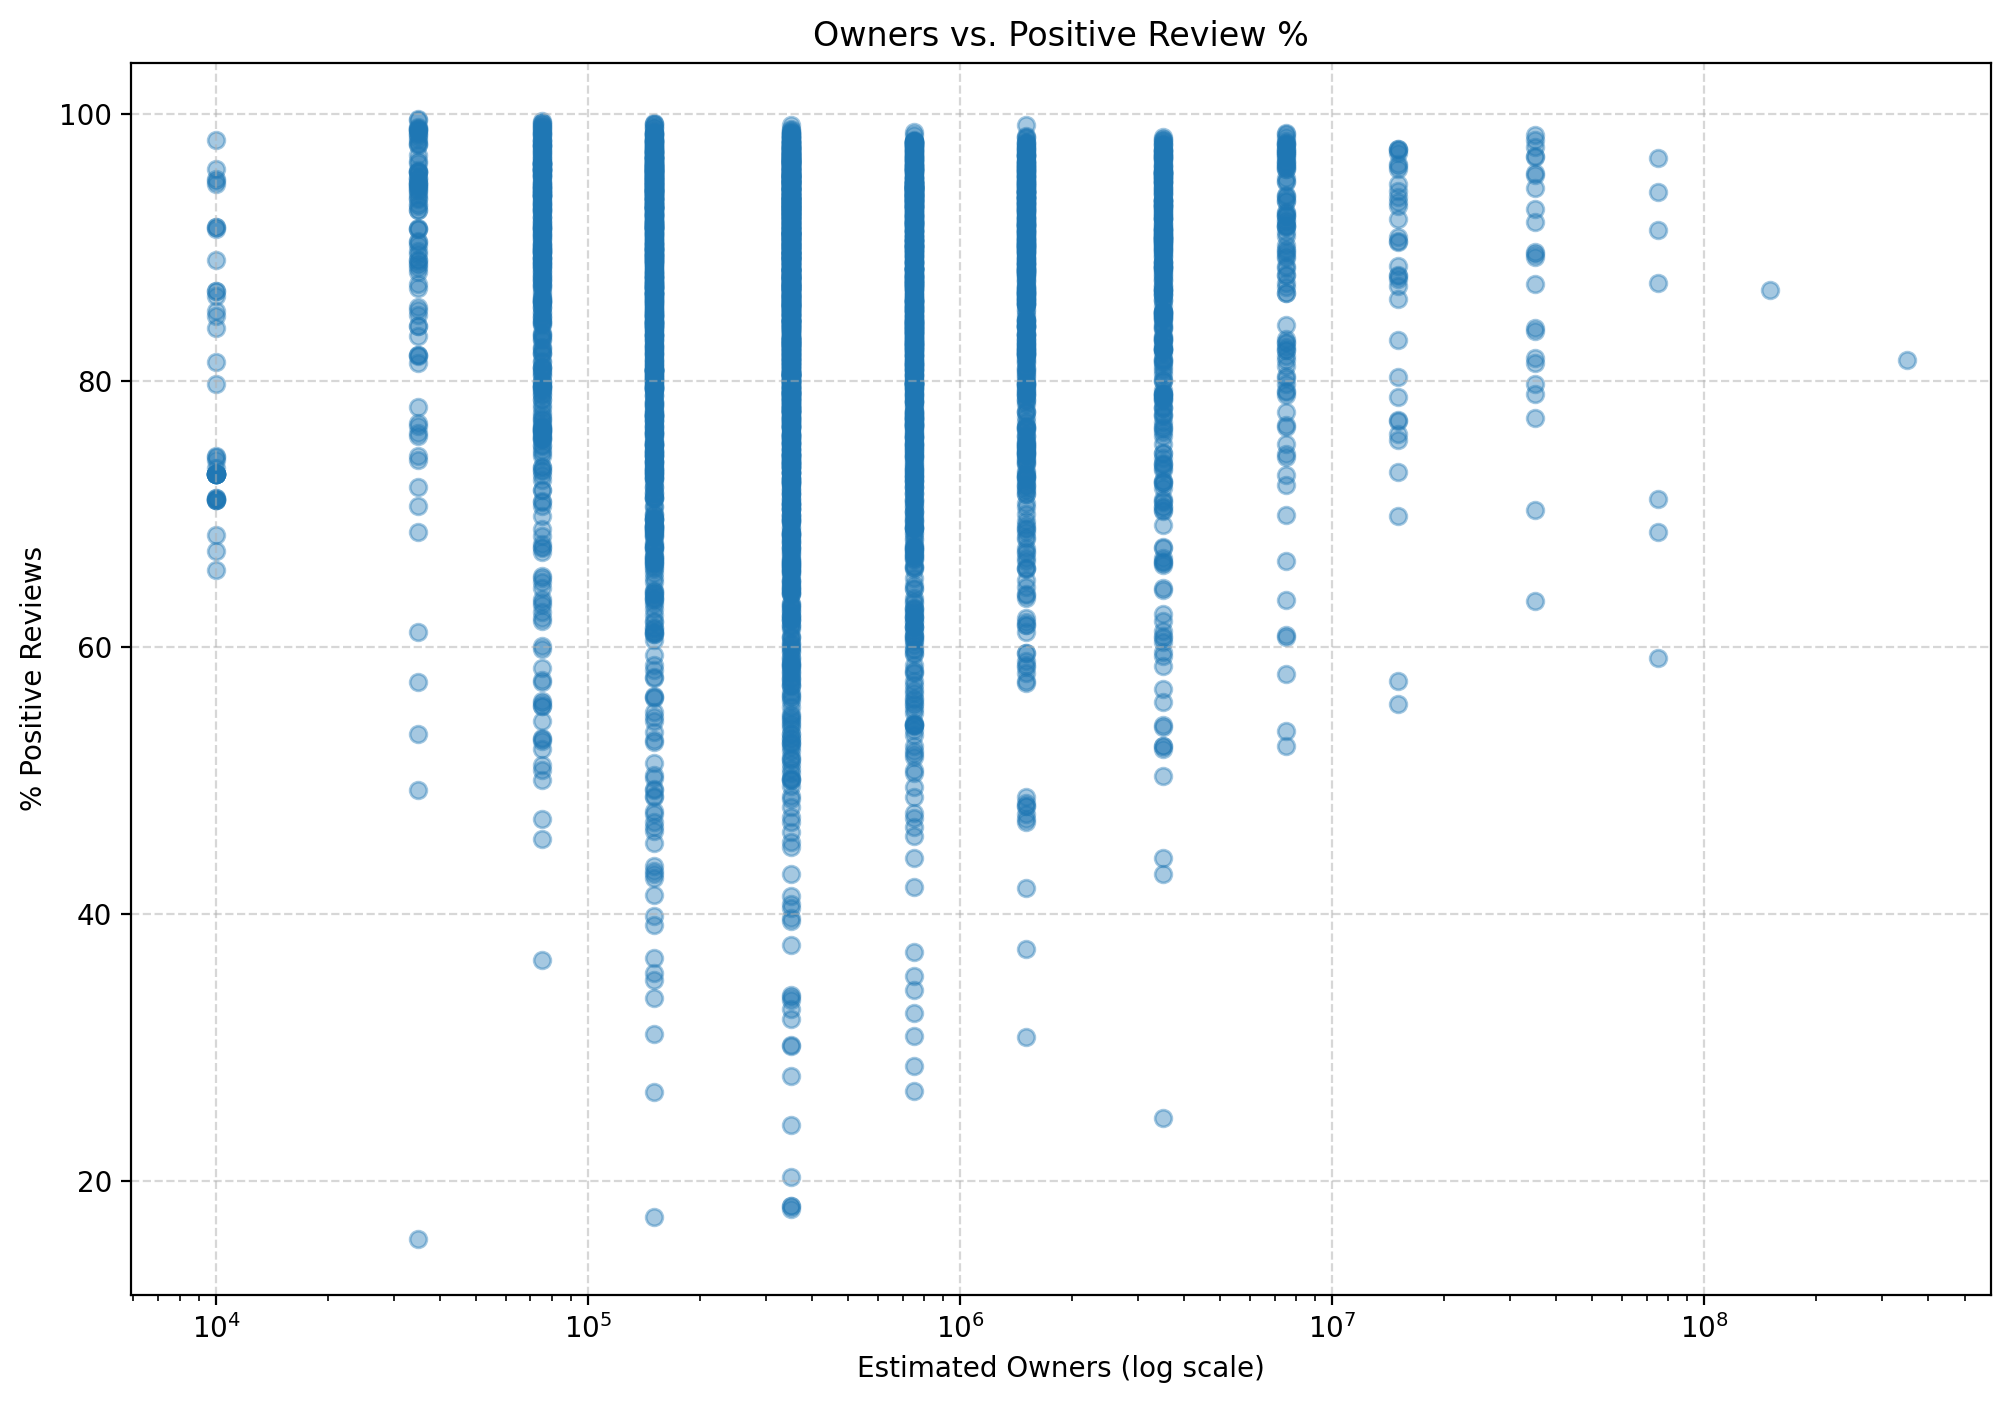

In [34]:
plt.figure(figsize=(12,8), dpi=200)
plt.scatter(
    df_reviews['estimated_owners'],
    df_reviews['positive_pct'],
    alpha=0.4
)
plt.xscale('log') # Scale the x axis to visualise well (large ownership scale)
plt.xlabel('Estimated Owners (log scale)')
plt.ylabel('% Positive Reviews')
plt.title('Owners vs. Positive Review %')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#### Observations:

Games regardless of low ownership are reviewed very highly - This is likely representative of 'niche' games.

On the higher end of game ownership positive review % compresses around 60 - 100%. This shows that major games avoid extreme negativity. The most highly sucsuccessful games approach the 80 - 100% range.

This information may inform feature engineering within the machine learning model, as game popularity appears to be correlated with review stability.

#### Changes to average positive review % by Year

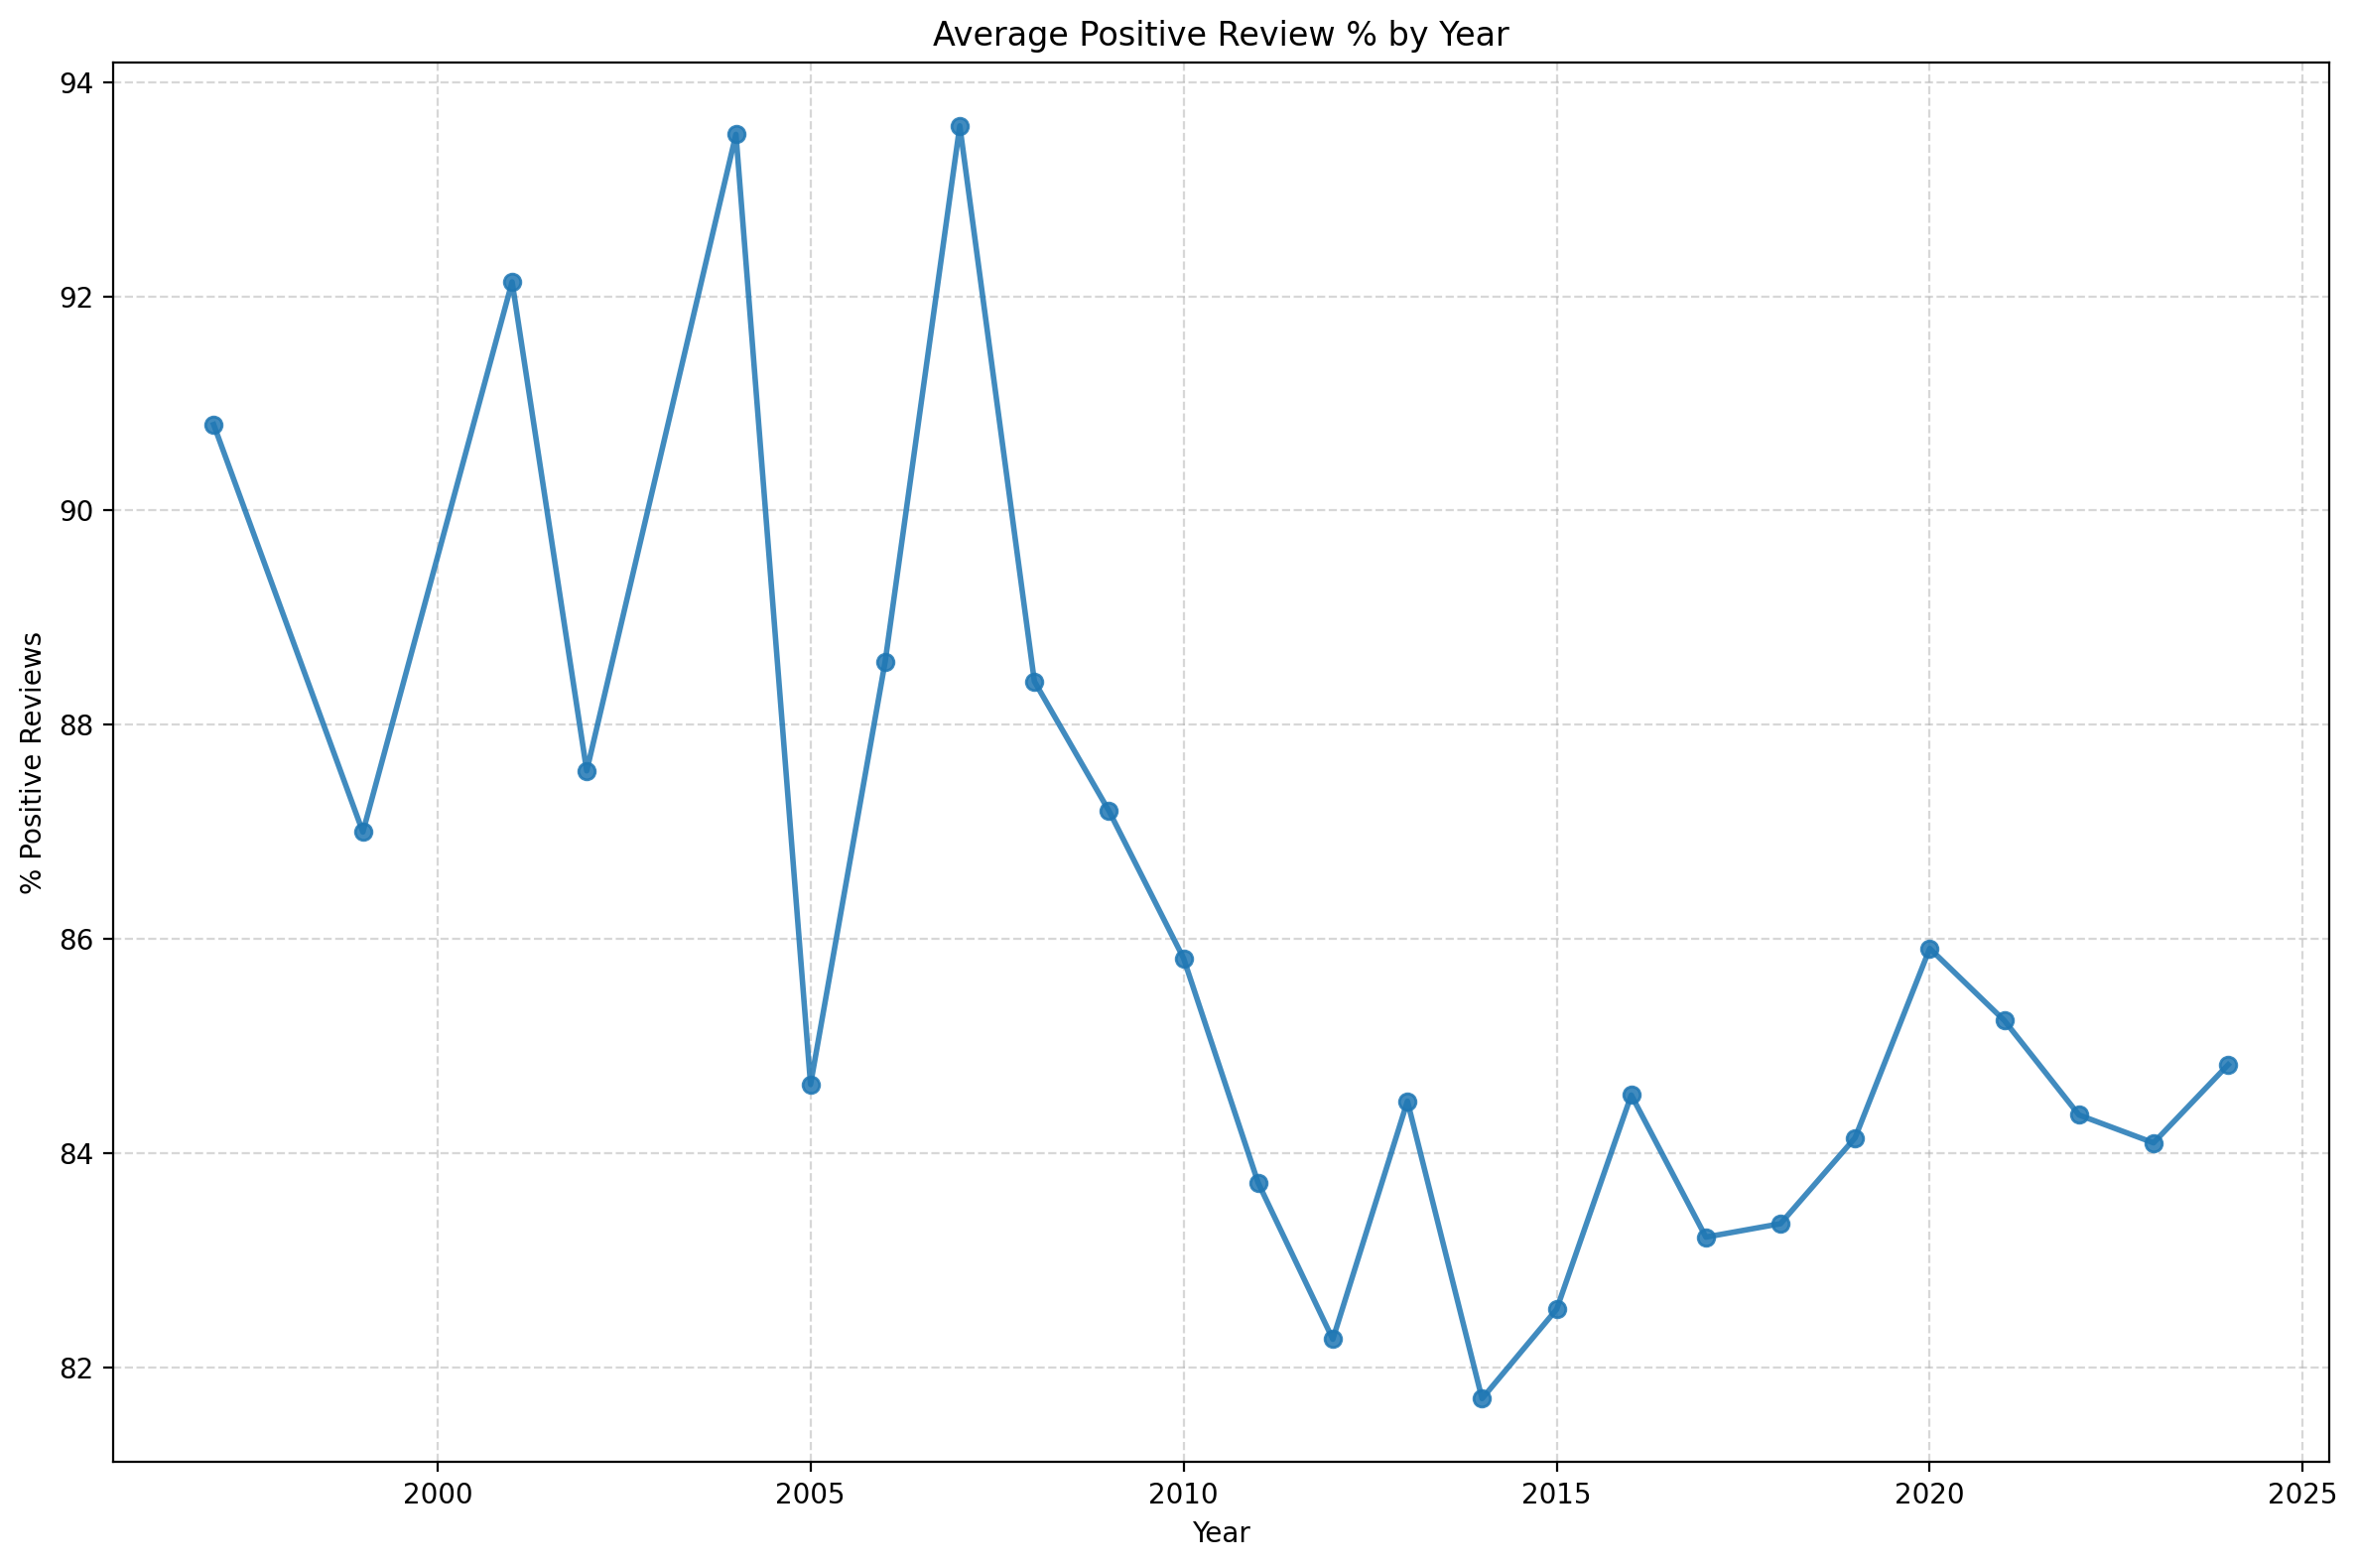

In [35]:
yearly_sentiment = (
    df_reviews.groupby('year')['positive_pct']
              .mean()
              .dropna()
)
plot_line(
    yearly_sentiment,
    'Average Positive Review % by Year',
    'Year',
    '% Positive Reviews'
)


#### Observations

High early averages from 1998 - 2008. Interestingly reviews consistently spike up and down despite rising every other Year.

There is a noticeable and sharp drop in 2008 which is stabilized in 2012.

Positive review average dropped to it's lowest point in 2014 before experiencing a slight uptick after 2018.

### Correlations

#### To further inform machine learning feature selection, correlations between features will be retreived.

In [ ]:
def plot_corr(show_all=True):
    # Get correlation matrix (Pearsons)
    corr_df = df.select_dtypes(include=[np.number]).copy() # Only want to correlate numeric features.

    filtered_cols = [ 
        col for col in corr_df
        if not (('lang' in col.lower()) or ('audio' in col.lower())) # Dont include the audio or lang indicators.
    ]

    corr_df = df[filtered_cols].copy()

    corr_matrix = corr_df.corr()

    if not show_all:
        # Only keep correlations above 0.6 to better visualise data.
        threshold = 0.6
        mask = corr_matrix.abs() >= threshold

        # ignore self‐correlations
        np.fill_diagonal(mask.values, False)

        # pick features with any True in their row
        features_to_keep = mask.any(axis=1)

        # filter the matrix
        corr_matrix = corr_matrix.loc[features_to_keep, features_to_keep]

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(corr_matrix, aspect='auto', interpolation='nearest')
    plt.colorbar(label='Correlation coefficient')
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix)), corr_matrix.index)
    # Add correlation annotations
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center')
    plt.title('Correlation Matrix of Numeric Features')


    plt.tight_layout()
    plt.show()


    print(corr_matrix)




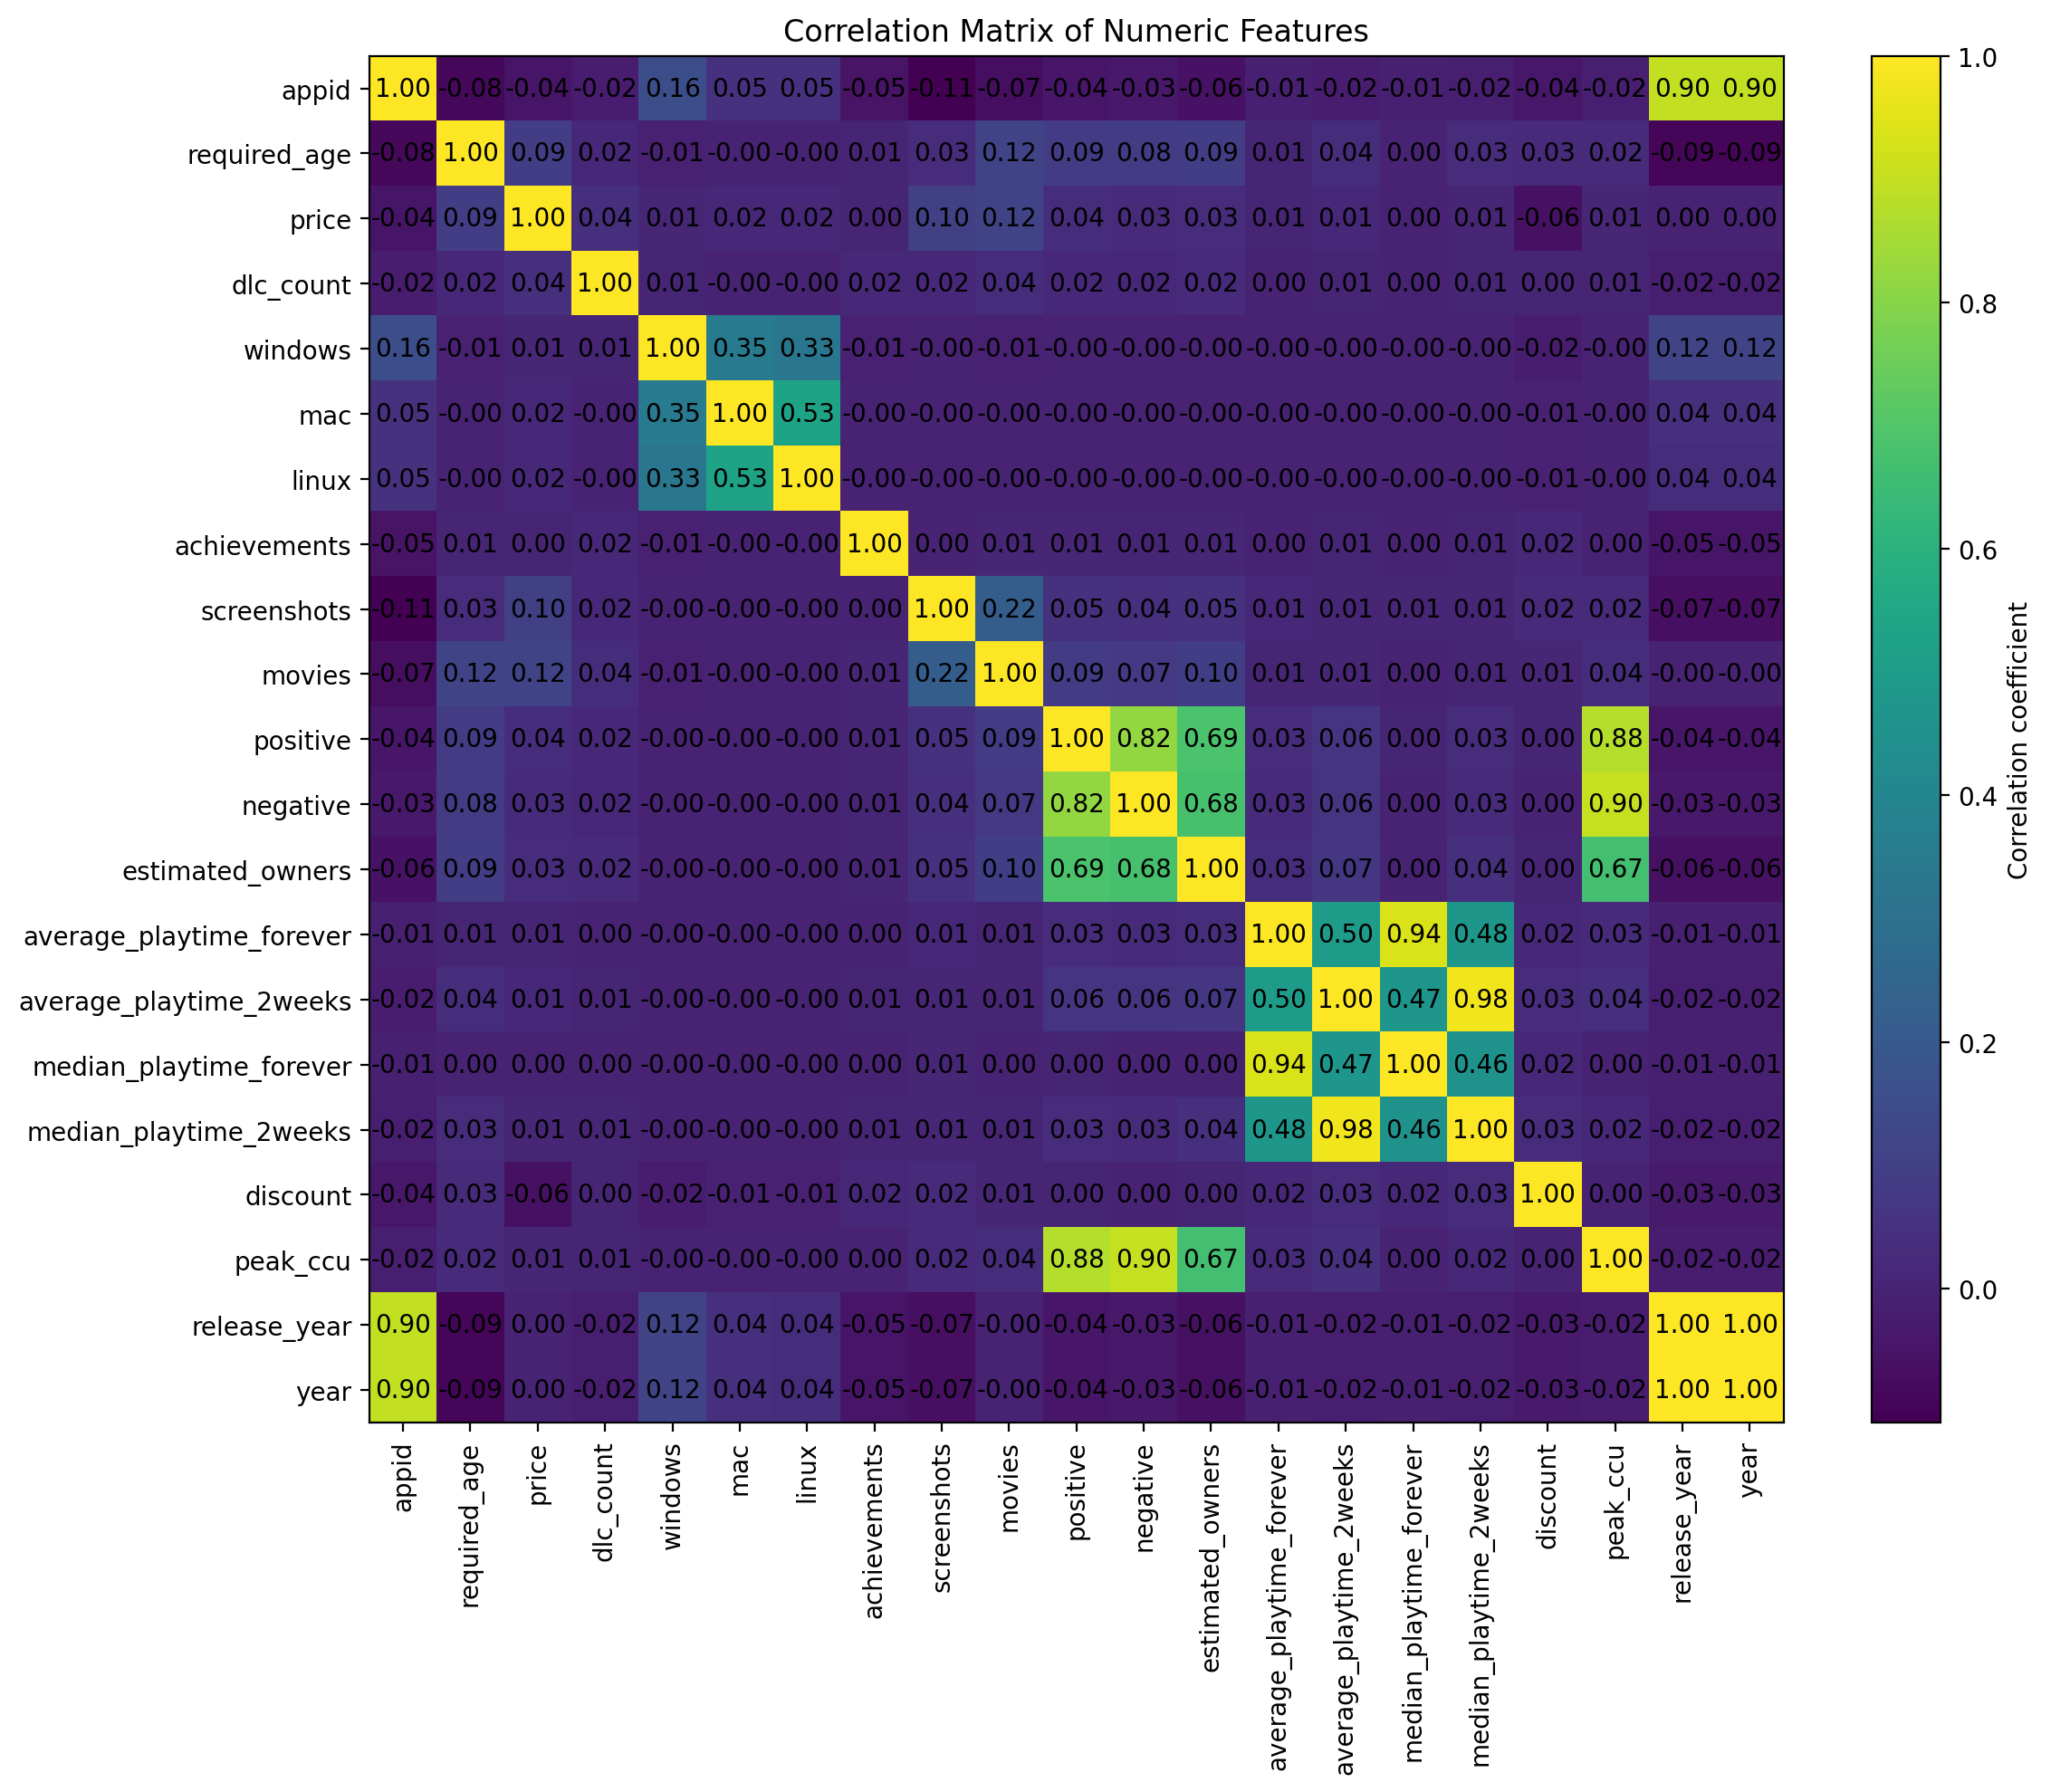

                             appid  required_age     price  dlc_count  \
appid                     1.000000     -0.084919 -0.044171  -0.023336   
required_age             -0.084919      1.000000  0.090601   0.016048   
price                    -0.044171      0.090601  1.000000   0.040264   
dlc_count                -0.023336      0.016048  0.040264   1.000000   
windows                   0.158652     -0.007754  0.011611   0.006216   
mac                       0.050840     -0.003952  0.018714  -0.001083   
linux                     0.049208     -0.003675  0.018495  -0.000848   
achievements             -0.051992      0.006987  0.004430   0.015836   
screenshots              -0.108904      0.033002  0.101658   0.020119   
movies                   -0.068412      0.119118  0.118390   0.037705   
positive                 -0.042316      0.088438  0.035285   0.018725   
negative                 -0.034361      0.083551  0.027031   0.016482   
estimated_owners         -0.056310      0.091665  0

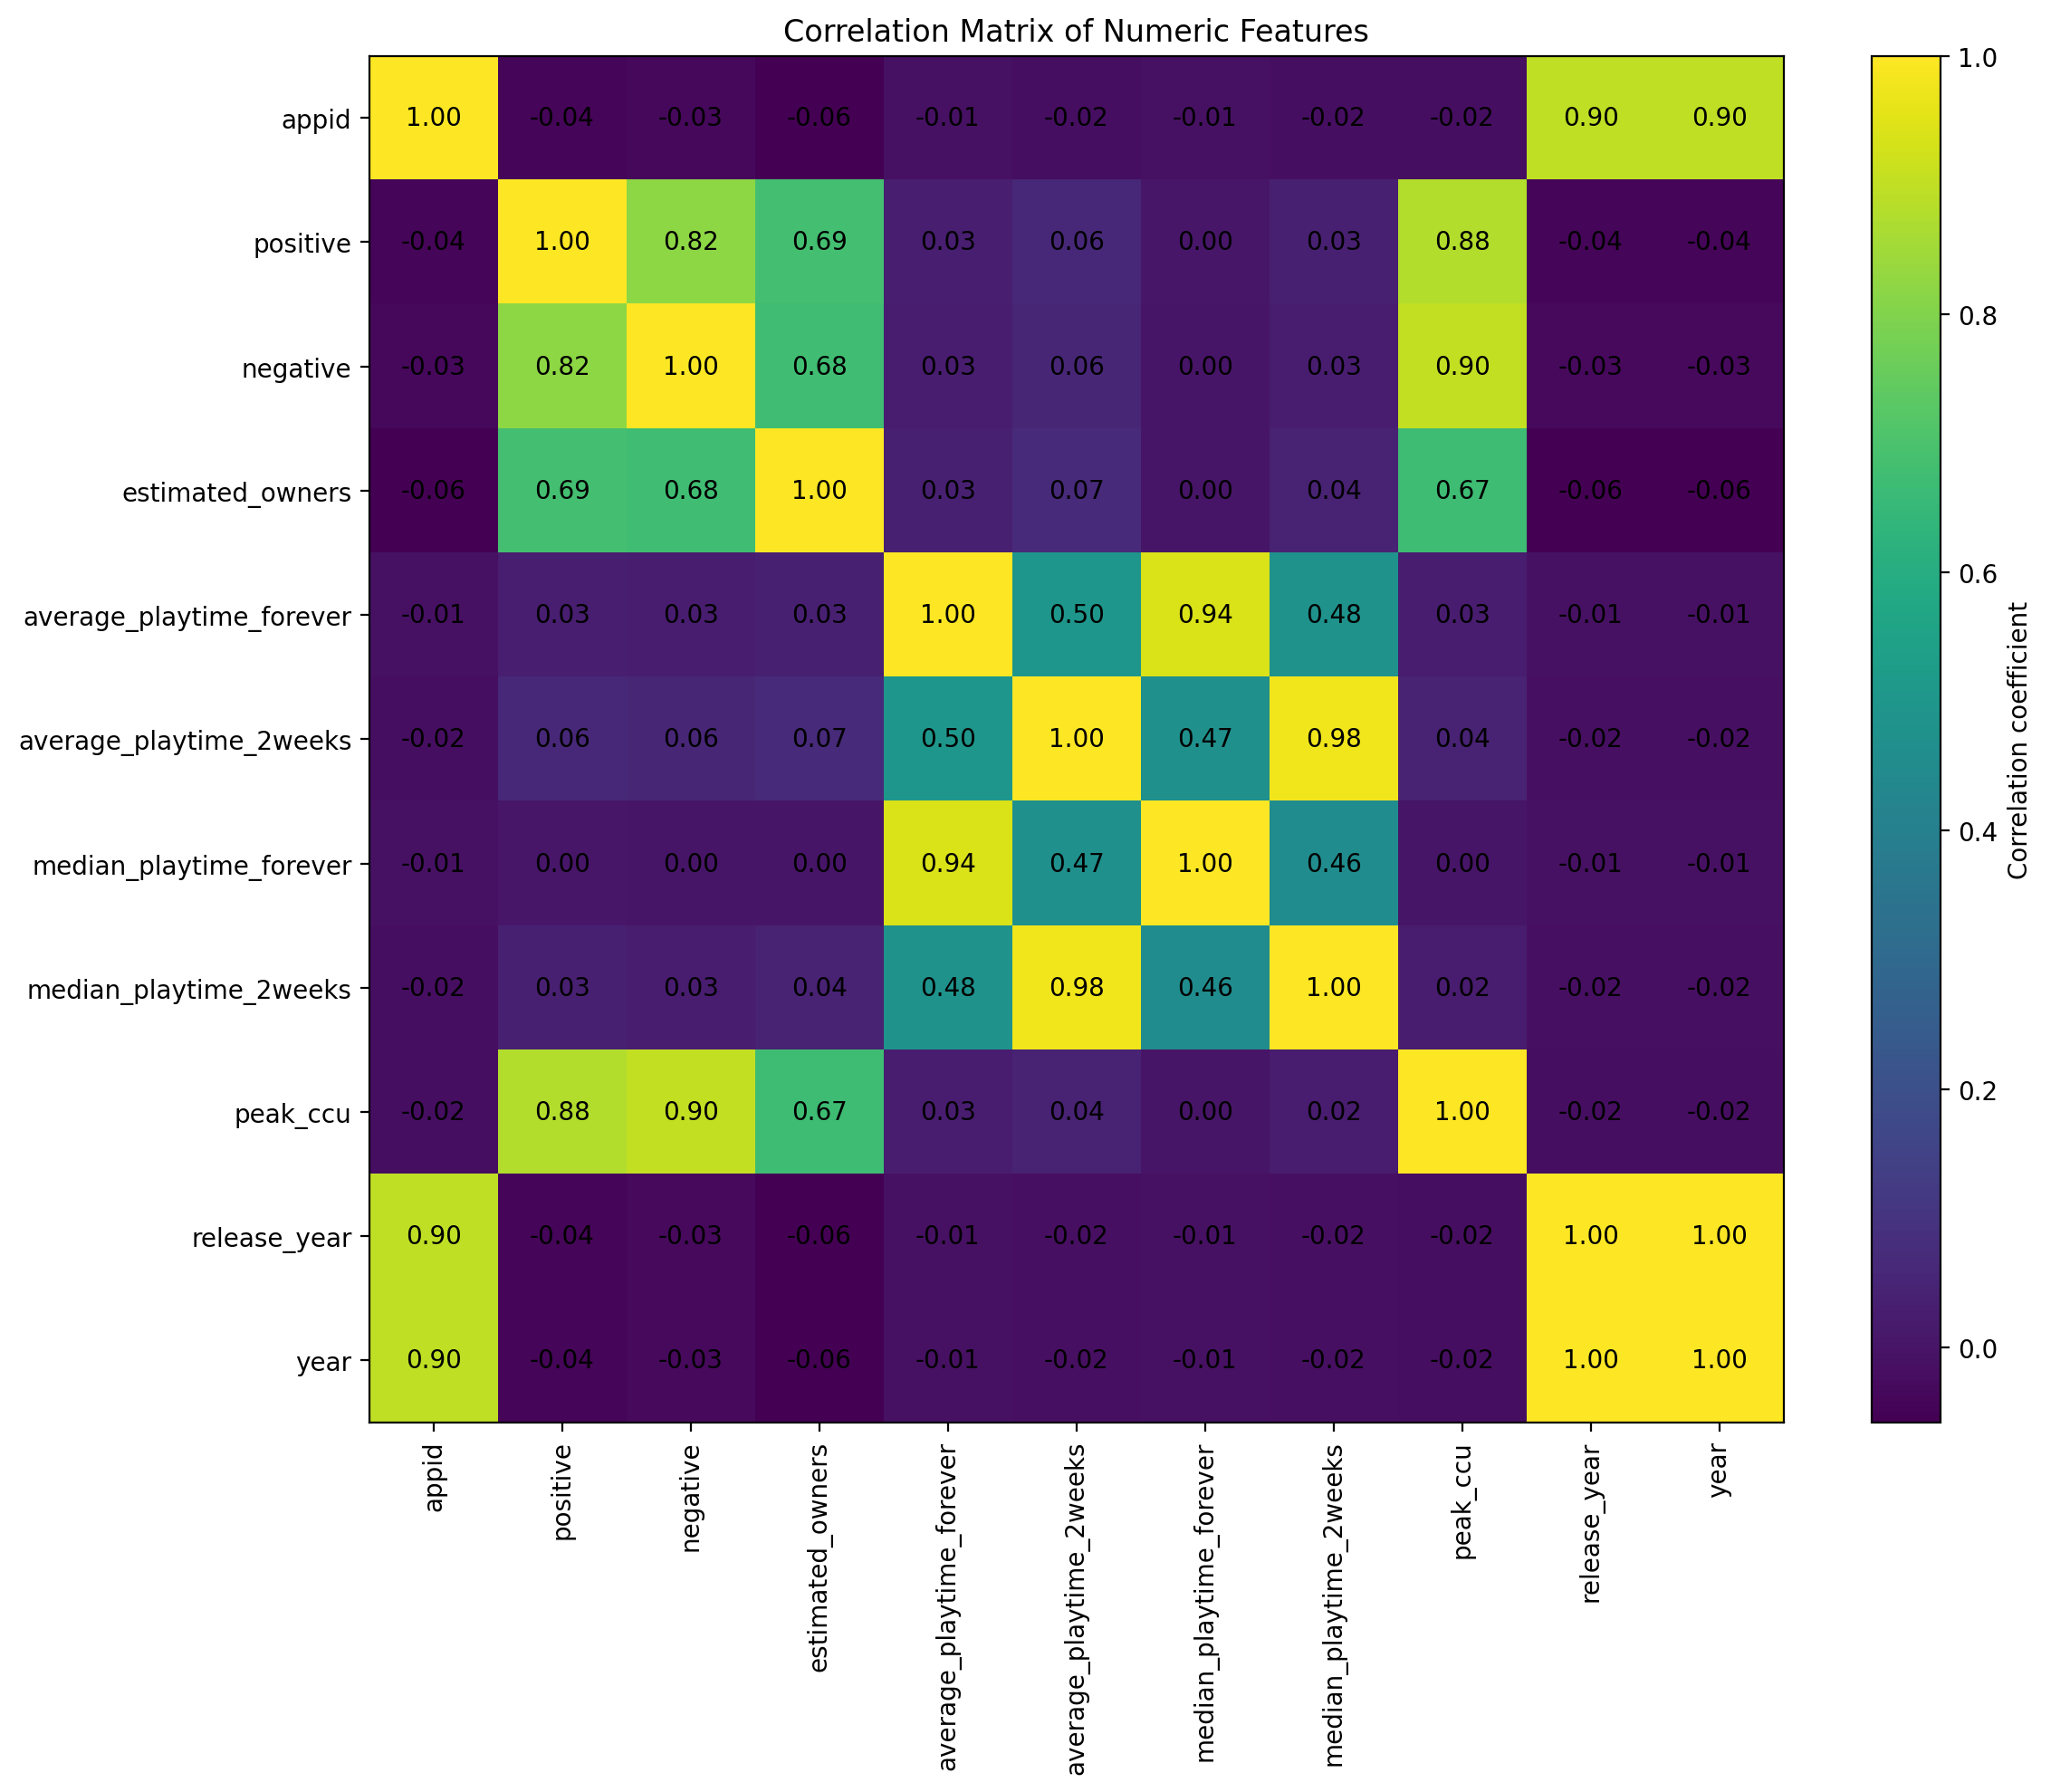

                             appid  positive  negative  estimated_owners  \
appid                     1.000000 -0.042316 -0.034361         -0.056310   
positive                 -0.042316  1.000000  0.820798          0.685352   
negative                 -0.034361  0.820798  1.000000          0.677360   
estimated_owners         -0.056310  0.685352  0.677360          1.000000   
average_playtime_forever -0.012286  0.031180  0.027678          0.034348   
average_playtime_2weeks  -0.018173  0.062818  0.055708          0.066667   
median_playtime_forever  -0.009640  0.003993  0.003087          0.003378   
median_playtime_2weeks   -0.017523  0.034008  0.026983          0.042403   
peak_ccu                 -0.017071  0.877876  0.902759          0.669524   
release_year              0.897372 -0.043689 -0.032698         -0.058291   
year                      0.897372 -0.043689 -0.032698         -0.058291   

                          average_playtime_forever  average_playtime_2weeks  \
appid   

In [ ]:
# Plot all correlations
plot_corr()

# Plot only correlations above threshold (0.6)
plot_corr(show_all=False)

# Machine Learning

The machine learning will take part in a third notebook, to continue the seperation of tasks and goals of the project.

The same SteamDataCleaned.csv dataset will be used.